In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os
import sys
sys.path.append('../')  

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

In [33]:
from test_data import experiment_data,add_noise,normalise_frobenius,normalise_minmax,create_data_2d
from numpy.linalg import matrix_rank, svd
from itertools import product
from utils import plot_result_jacobi
from error_bounds import *

In [35]:
def get_derivatives(u,dt,dx,fd_order,drop_endpoints=True,remove_endpoints=True):
    #Compute the derivatives
    ut_fd = ps.FiniteDifference(order=fd_order, d=1, axis=1, drop_endpoints=drop_endpoints)._differentiate(u, t=dt)
    utx_fd = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=drop_endpoints)._differentiate(ut_fd, dx)
    ux_fd = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=drop_endpoints)._differentiate(u, dx)
    uxx_fd = ps.FiniteDifference(order=fd_order, d=2, axis=0, drop_endpoints=drop_endpoints)._differentiate(u, dx) 

    if remove_endpoints:
        #Filter out the boundary values
        ut_fd= ut_fd[~np.isnan(ut_fd).all(axis=1)][:, ~np.isnan(ut_fd).all(axis=0)]
        utx_fd= utx_fd[~np.isnan(utx_fd).all(axis=1)][:, ~np.isnan(utx_fd).all(axis=0)]
        ux_fd= ux_fd[~np.isnan(ux_fd).all(axis=1)][:, ~np.isnan(ux_fd).all(axis=0)]
        uxx_fd= uxx_fd[~np.isnan(uxx_fd).all(axis=1)][:, ~np.isnan(uxx_fd).all(axis=0)]
    return ut_fd, utx_fd,ux_fd, uxx_fd

def drop_endpoints(func_fd,func_true):
    func_true = func_true[~np.isnan(func_fd).all(axis=1)][:, ~np.isnan(func_fd).all(axis=0)]
    func_fd= func_fd[~np.isnan(func_fd).all(axis=1)][:, ~np.isnan(func_fd).all(axis=0)]
    return func_fd,func_true

We want to get a threshold and error bound for analysing a analytic or polynomial PDE as unique. We can reuse the functions from the SFranco method.

## Easy examples: $u_1 = x^2 + t^2$ and $u_2 = exp(x-at)$

In [113]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-2, T_end=2, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
"""
#not unique
u = X**2 + T**2
ux = 2*X
ut = 2*T
utx = 0*T
uxx = 2*np.ones(X.shape)
"""

#not unqiue
u = np.exp(X-a*T)
ux = u
ut = -a*u
utx = -a*u
uxx = u
"""
#analytic unique
u=(X + T)*np.arccos(1/np.cosh(a*T))
ut = a*(T + X)*np.sinh(T*a)/(np.sqrt(1 - 1/np.cosh(T*a)**2)*np.cosh(T*a)**2) + np.arccos(1/np.cosh(T*a))
ux = np.arccos(1/np.cosh(T*a))
utx = a*np.sinh(T*a)/(np.sqrt(1 - 1/np.cosh(T*a)**2)*np.cosh(T*a)**2)
uxx = np.zeros(X.shape)
"""
print(f"a {a}")
dt=t[1]-t[0]
dx=x[1]-x[0]

a 0.052713623672570736


#### Compare the error on finite differences on the Jacobian of $g = ( u | u_x)$

In [114]:
#Compute the derivatives
fd_order=8
ut_fd, utx_fd,ux_fd, uxx_fd = get_derivatives(u,dt,dx,fd_order,drop_endpoints=True,remove_endpoints=False)

#Filter out the boundary values
ut_fd,ut = drop_endpoints(ut_fd,ut)
utx_fd,utx = drop_endpoints(utx_fd,utx)
ux_fd,ux = drop_endpoints(ux_fd,ux)
uxx_fd,uxx = drop_endpoints(uxx_fd,uxx)

##### Compare the upper bounds for different derivatives and the Jacobian

###### Without noise

Lets calculate an upper bound for the different derivatives

In [115]:
eps=1e-15

bound_ut = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=infinity_norm(a**(fd_order+1)*u),Cxi=1.0,h=dt)
bound_ux = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=infinity_norm(u),Cxi=1.0,h=dx)
bound_uxx = upper_bound_central_differences(eps,fd_order,order_derivative=2,Cu=infinity_norm(u),Cxi=1.0,h=dx)
bound_utx = upper_bound_central_differences(bound_ut,fd_order,order_derivative=1,Cu=infinity_norm(ut),Cxi=1.0,h=dx)

print(f" |ut_fd - ut| \t= {infinity_norm((ut_fd-ut).flatten()):.3e} <= {bound_ut:.3e}")
print(f" |ux_fd - ux| \t= {infinity_norm((ux_fd-ux).flatten()):.3e} <= {bound_ux:.3e}")
print(f" |uxx_fd - uxx|\t= {infinity_norm((uxx_fd-uxx).flatten()):.3e} <= {bound_uxx:.3e}")
print(f" |utx_fd - utx|\t= {infinity_norm((utx_fd-utx).flatten()):.3e} <= {bound_utx:.3e}")

 |ut_fd - ut| 	= 1.153e-12 <= 2.552e-14
 |ux_fd - ux| 	= 2.052e-09 <= 3.077e-09
 |uxx_fd - uxx|	= 4.095e-10 <= 6.154e-09
 |utx_fd - utx|	= 1.081e-10 <= 1.599e-10


Check wether upper bound is correct:
|JG-JG_fd|= 8.484e-11 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 8.127e-11 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 7.783e-11 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 7.458e-11 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 2.355e-10 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 2.255e-10 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 2.159e-10 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 2.070e-10 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 6.527e-10 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 6.251e-10 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 5.987e-10 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 5.735e-10 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 1.813e-09 <= 6.883e-09
Check wether upper bound is correct:
|JG-JG_fd|= 1.738e-09 <= 6.

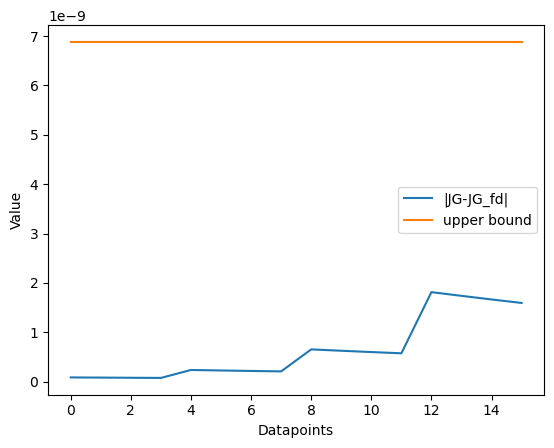

In [116]:
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)
jacobians =[]
upperbounds=[]
for i in range(space_range):
    for j in range(time_range):
        x_i, t_j = i * 10 + 10, j * 10 + 10
        jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
        jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)

        jacobian_diff = np.linalg.norm(jacobian_fd -jacobian)
        nr_datapoints=1
        upperbound = np.sqrt(bound_ut**2+bound_ux**2 + bound_uxx**2+bound_utx**2)

        jacobians.append(jacobian_diff)
        upperbounds.append(upperbound)

        print("Check wether upper bound is correct:")
        print(f"|JG-JG_fd|= {jacobian_diff:.3e} <= {upperbound:.3e}")

plt.plot(jacobians,label="|JG-JG_fd|")
plt.plot(upperbounds, label="upper bound")
plt.xlabel("Datapoints")
plt.ylabel("Value")
plt.legend()
plt.show()

Noise level 0
 |ut_fd - ut| 	= 1.153e-12 <= 1.622e-21
 |ux_fd - ux| 	= 2.052e-09 <= 3.077e-09
 |uxx_fd - uxx|	= 4.095e-10 <= 6.154e-09
 |utx_fd - utx|	= 1.081e-10 <= 1.594e-10
Upper bound 6.882e-09


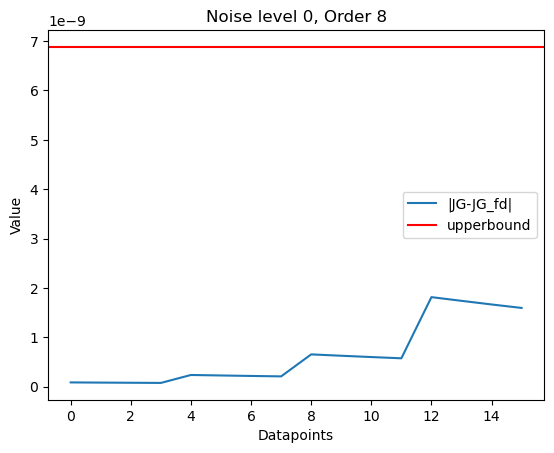

Noise level 1e-10
 |ut_fd - ut| 	= 2.372e-07 <= 4.778e-07
 |ux_fd - ux| 	= 1.905e-07 <= 3.853e-07
 |uxx_fd - uxx|	= 6.770e-06 <= 1.170e-05
 |utx_fd - utx|	= 2.806e-06 <= 9.755e-06
Upper bound 1.524e-05


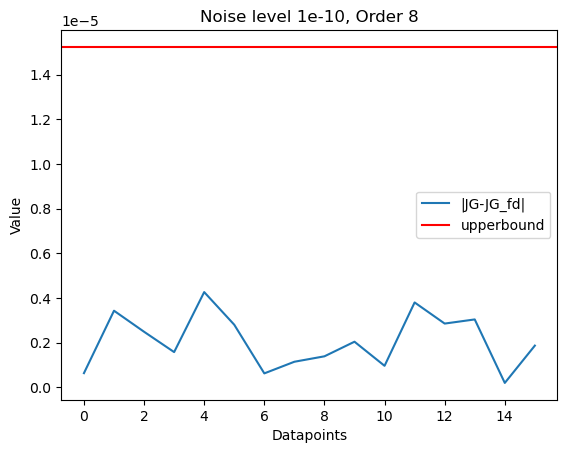

Noise level 1e-09
 |ut_fd - ut| 	= 2.808e-06 <= 5.475e-06
 |ux_fd - ux| 	= 1.994e-06 <= 4.383e-06
 |uxx_fd - uxx|	= 6.572e-05 <= 1.340e-04
 |utx_fd - utx|	= 2.949e-05 <= 1.118e-04
Upper bound 1.746e-04


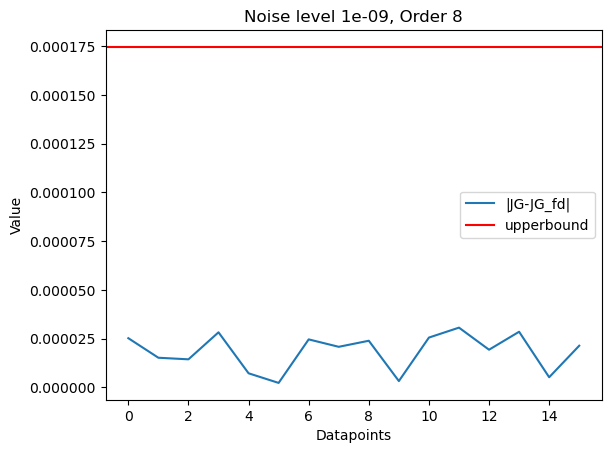

Noise level 1e-08
 |ut_fd - ut| 	= 2.558e-05 <= 4.519e-05
 |ux_fd - ux| 	= 1.959e-05 <= 3.616e-05
 |uxx_fd - uxx|	= 5.866e-04 <= 1.106e-03
 |utx_fd - utx|	= 2.701e-04 <= 9.227e-04
Upper bound 1.441e-03


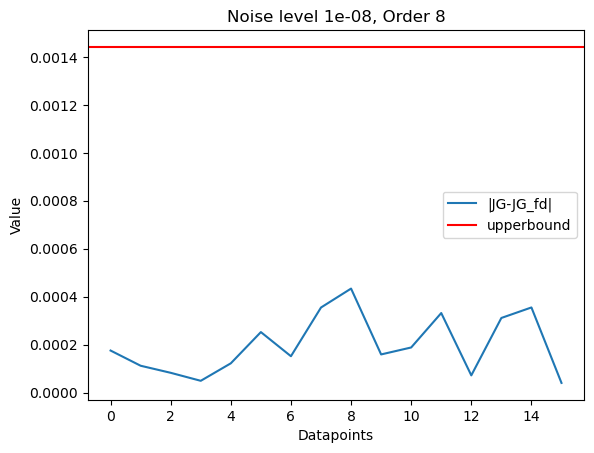

Noise level 1e-07
 |ut_fd - ut| 	= 2.655e-04 <= 4.917e-04
 |ux_fd - ux| 	= 2.116e-04 <= 3.933e-04
 |uxx_fd - uxx|	= 5.933e-03 <= 1.203e-02
 |utx_fd - utx|	= 2.786e-03 <= 1.004e-02
Upper bound 1.568e-02


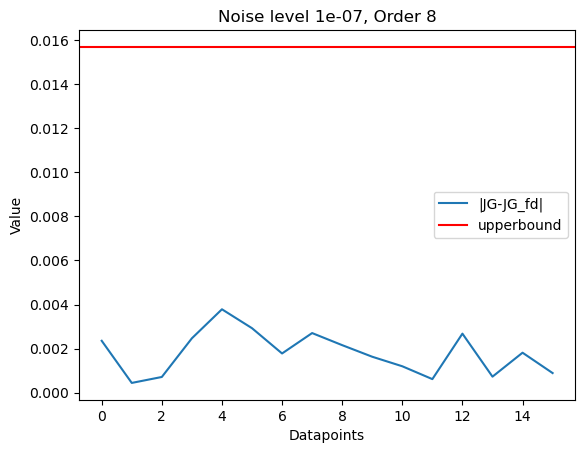

Noise level 1e-06
 |ut_fd - ut| 	= 2.908e-03 <= 5.350e-03
 |ux_fd - ux| 	= 2.131e-03 <= 4.280e-03
 |uxx_fd - uxx|	= 6.891e-02 <= 1.309e-01
 |utx_fd - utx|	= 2.775e-02 <= 1.092e-01
Upper bound 1.706e-01


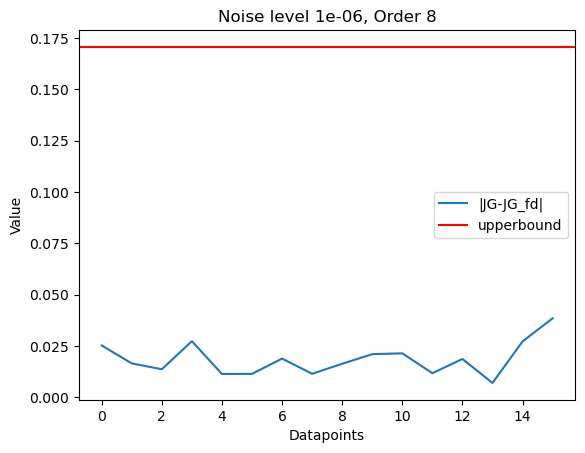

Noise level 1e-05
 |ut_fd - ut| 	= 2.172e-02 <= 3.951e-02
 |ux_fd - ux| 	= 2.102e-02 <= 3.161e-02
 |uxx_fd - uxx|	= 5.931e-01 <= 9.667e-01
 |utx_fd - utx|	= 2.816e-01 <= 8.067e-01
Upper bound 1.260e+00


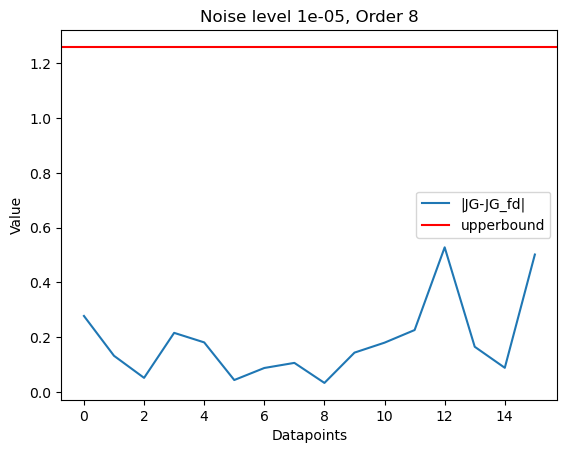

Noise level 0.0001
 |ut_fd - ut| 	= 2.454e-01 <= 4.391e-01
 |ux_fd - ux| 	= 2.403e-01 <= 3.513e-01
 |uxx_fd - uxx|	= 6.361e+00 <= 1.074e+01
 |utx_fd - utx|	= 2.962e+00 <= 8.964e+00
Upper bound 1.400e+01


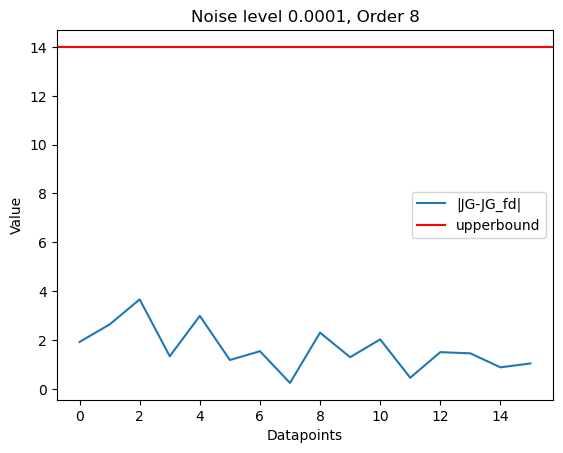

Noise level 0.001
 |ut_fd - ut| 	= 2.312e+00 <= 4.558e+00
 |ux_fd - ux| 	= 2.256e+00 <= 3.647e+00
 |uxx_fd - uxx|	= 6.551e+01 <= 1.115e+02
 |utx_fd - utx|	= 2.806e+01 <= 9.307e+01
Upper bound 1.454e+02


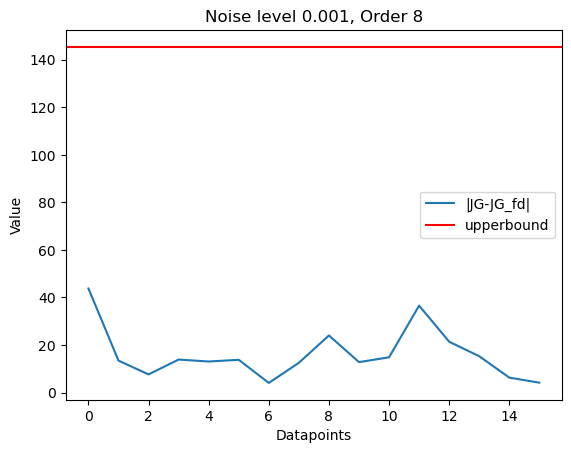

Noise level 0.01
 |ut_fd - ut| 	= 2.378e+01 <= 4.454e+01
 |ux_fd - ux| 	= 2.030e+01 <= 3.564e+01
 |uxx_fd - uxx|	= 5.802e+02 <= 1.090e+03
 |utx_fd - utx|	= 2.907e+02 <= 9.094e+02
Upper bound 1.421e+03


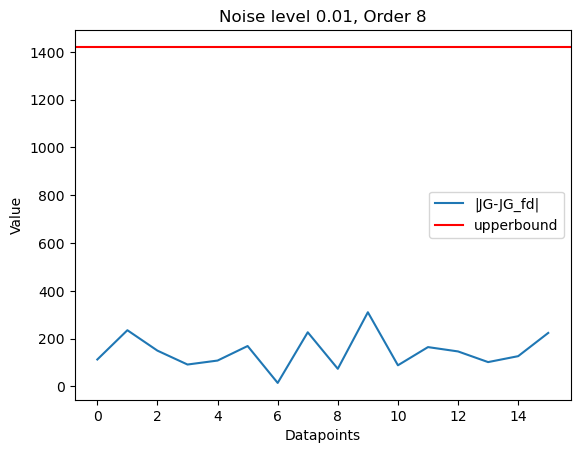

In [117]:
M=infinity_norm(u)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,2)
unorm2=np.sqrt(np.mean(np.square(u)))

for noise_level in noise_levels: 
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    print(f"Noise level {noise_level}")
    #Calculate upper bounds
    eps = infinity_norm(u-u_noise)
    bound_ut = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=infinity_norm(a**(fd_order+1)*u),Cxi=1.0,h=dt)
    bound_ux = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=infinity_norm(u),Cxi=1.0,h=dx)
    bound_uxx = upper_bound_central_differences(eps,fd_order,order_derivative=2,Cu=infinity_norm(u),Cxi=1.0,h=dx)
    bound_utx = upper_bound_central_differences(bound_ut,fd_order,order_derivative=1,Cu=infinity_norm(ut),Cxi=1.0,h=dx)
    
    #Calculate derivatives
    ut_fd, utx_fd,ux_fd, uxx_fd= get_derivatives(u_noise,dt,dx,fd_order)
    
    print(f" |ut_fd - ut| \t= {infinity_norm((ut_fd-ut).flatten()):.3e} <= {bound_ut:.3e}")
    print(f" |ux_fd - ux| \t= {infinity_norm((ux_fd-ux).flatten()):.3e} <= {bound_ux:.3e}")
    print(f" |uxx_fd - uxx|\t= {infinity_norm((uxx_fd-uxx).flatten()):.3e} <= {bound_uxx:.3e}")
    print(f" |utx_fd - utx|\t= {infinity_norm((utx_fd-utx).flatten()):.3e} <= {bound_utx:.3e}")
    
    jacobians =[]
    #Calculate upper bound which stays constant for all data points(only changes in noise level)
    nr_datapoints=1
    upperbound = np.sqrt(bound_ut**2+bound_ux**2 + bound_uxx**2+bound_utx**2)
    print(f"Upper bound {upperbound:.3e}")
    for i in range(space_range):
        for j in range(time_range):
            #Compute differenc between true Jacobian and finite difference Jacobian
            x_i, t_j = i * 10 + 10, j * 10 + 10
            jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
            jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
            jacobian_diff = np.linalg.norm(jacobian_fd -jacobian)    
            jacobians.append(jacobian_diff)
    
            #print("Check wether upper bound is correct:")
            #print(f"|JG-JG_fd|= {jacobian_diff:.3e} <= {upperbound:.3e}")
    plt.title(f"Noise level {noise_level}, Order {fd_order}")
    plt.plot(jacobians,label="|JG-JG_fd|")
    plt.axhline(y=upperbound, color='r', linestyle='-',label="upperbound")
    plt.xlabel("Datapoints")
    plt.ylabel("Value")
    plt.legend()
    filename = f"Images/noise_{noise_level}_order_{fd_order}.png"
    plt.savefig(filename)
    plt.show()

Compare Jacobians and singular values

In [118]:
def get_upper_bound_jacobian(eps,fd_order,Cut,Cux,Cuxx,Cutx,dt,dx,Cxi=1.0):

    bound_ut = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=Cut,Cxi=Cxi,h=dt)
    bound_ux = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=Cux,Cxi=Cxi,h=dx)
    bound_uxx = upper_bound_central_differences(eps,fd_order,order_derivative=2,Cu=Cuxx,Cxi=Cxi,h=dx)
    bound_utx = upper_bound_central_differences(bound_ut,fd_order,order_derivative=1,Cu=Cutx,Cxi=Cxi,h=dx)

    upper_bound = np.sqrt(bound_ut**2+bound_ux**2 + bound_uxx**2+bound_utx**2)
    
    return upper_bound

In [135]:
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)

#For saving results
svs = np.zeros([space_range, time_range])
svs_fd = np.zeros([space_range, time_range])
upper_bounds = np.zeros([space_range, time_range])
lower_bounds = np.zeros([space_range, time_range])

ut_fd, utx_fd,ux_fd, uxx_fd = get_derivatives(u,dt,dx,fd_order)

for i in range(space_range):
    for j in range(time_range):
        x_i, t_j = i * 10 + 10, j * 10 + 10
        jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
        jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
        

        sv = svd(jacobian, compute_uv=False)
        sv_fd = svd(jacobian_fd, compute_uv=False)
        sv_min,sv_min_fd =sv  [-1],sv_fd[-1]
        sv_max,sv_max_fd =sv[0],sv_fd[0]

        #Save the results 
        svs[i,j] = sv_min/sv_max
        svs_fd[i,j] =sv_min_fd/sv_max_fd
        jacobian_diff=np.linalg.norm(jacobian_fd -jacobian)
        upper_bound_jacobian = get_upper_bound_jacobian(1e-16,fd_order,infinity_norm(a**(fd_order+1)*u),
                                                        infinity_norm(u),infinity_norm(u),infinity_norm(ut),dt,dx)
        print("Jacobian diff ", jacobian_diff, "upper_bound_jacobian",upper_bound_jacobian)
        
        C1=sv_max
        C=sv_max
        C2=1e-3
        lower_bound = lower_bound_nonsingular_matrix(C1,C2,jacobian_diff)
        upper_bound = upper_bound_singular_matrix(C,jacobian_diff)

        lower_bound_nonexact = lower_bound_nonsingular_matrix(C1,C2,upper_bound_jacobian)
        upper_bound_nonexact = upper_bound_singular_matrix(C,upper_bound_jacobian)

        lower_bounds[i,j]=lower_bound
        upper_bounds[i,j]=upper_bound
        
        print(f" Comparison at x = {x_i}, t = {t_j} ")
        print(f" \t \t \t \t Original \t FD \t \t diff")
        print(f" Smallest singular values \t {sv_min:.3e}\t  {sv_min_fd:.3e} \t {np.abs(sv_min-sv_min_fd):.3e}")
        print(f" Biggest singular values \t {sv_max:.3e}\t  {sv_max_fd:.3e} \t {np.abs(sv_max-sv_max_fd):.3e}")
        print(f" Differences Jacobian \t \t {jacobian_diff:.3e} <= {upper_bound_jacobian:.3e}")
        print(" Bounds with jacobian difference")
        print(f" \t Lower bound for uniqueness: \t  {svs_fd[i,j]:.3e} >= {lower_bound:.3e}")
        print(f" \t Upper bound for non uniqueness:  {svs_fd[i,j]:.3e} <= {upper_bound:.3e}")
        print(" Bounds with upper bound on jacobian difference")
        print(f" \t Lower bound for uniqueness: \t  {svs_fd[i,j]:.3e} >= {lower_bound_nonexact:.3e}")
        print(f" \t Upper bound for non uniqueness:  {svs_fd[i,j]:.3e} <= {upper_bound_nonexact:.3e}")
        print(f" True ratio: \t  \t \t  {svs[i,j]:.3e} ")

Jacobian diff  8.484346174286511e-11 upper_bound_jacobian 6.882004452773882e-09
 Comparison at x = 10, t = 10 
 	 	 	 	 Original 	 FD 	 	 diff
 Smallest singular values 	 5.448e-02	  5.448e-02 	 5.089e-12
 Biggest singular values 	 6.287e+00	  6.287e+00 	 7.055e-11
 Differences Jacobian 	 	 8.484e-11 <= 6.882e-09
 Bounds with jacobian difference
 	 Lower bound for uniqueness: 	  8.666e-03 >= 1.591e-04
 	 Upper bound for non uniqueness:  8.666e-03 <= 1.350e-11
 Bounds with upper bound on jacobian difference
 	 Lower bound for uniqueness: 	  8.666e-03 >= 1.591e-04
 	 Upper bound for non uniqueness:  8.666e-03 <= 1.095e-09
 True ratio: 	  	 	  8.666e-03 
Jacobian diff  8.126815881210824e-11 upper_bound_jacobian 6.882004452773882e-09
 Comparison at x = 10, t = 20 
 	 	 	 	 Original 	 FD 	 	 diff
 Smallest singular values 	 5.219e-02	  5.219e-02 	 4.868e-12
 Biggest singular values 	 6.022e+00	  6.022e+00 	 6.756e-11
 Differences Jacobian 	 	 8.127e-11 <= 6.882e-09
 Bounds with jacobian dif

In [136]:
from matplotlib.colors import LinearSegmentedColormap
green=(100/255,250/255,100/255)#(0,1,0)
red=(241/255,13/255,30/255)
cmap_green_red = LinearSegmentedColormap.from_list('RedGreen', [green,red], N=256)
cmap_red_green = LinearSegmentedColormap.from_list('GreenRed', [red,green], N=256)

In [137]:
lower_bounds

array([[1.59060570e-04, 1.66054593e-04, 1.73356148e-04, 1.80978759e-04],
       [5.73330221e-05, 5.98540022e-05, 6.24858317e-05, 6.52333850e-05],
       [2.06655524e-05, 2.15742341e-05, 2.25228712e-05, 2.35132207e-05],
       [7.44884403e-06, 7.77637632e-06, 8.11831048e-06, 8.47527977e-06]])

In [138]:
upper_bounds

array([[1.34952505e-11, 1.34949521e-11, 1.34931736e-11, 1.34965728e-11],
       [1.35005476e-11, 1.34995845e-11, 1.34913352e-11, 1.35034265e-11],
       [1.34876262e-11, 1.34868218e-11, 1.34852258e-11, 1.34839214e-11],
       [1.35031518e-11, 1.35121130e-11, 1.35109369e-11, 1.35065870e-11]])

In [139]:
svs

array([[0.00866609, 0.00866609, 0.00866609, 0.00866609],
       [0.00866609, 0.00866609, 0.00866609, 0.00866609],
       [0.00866609, 0.00866609, 0.00866609, 0.00866609],
       [0.00866609, 0.00866609, 0.00866609, 0.00866609]])

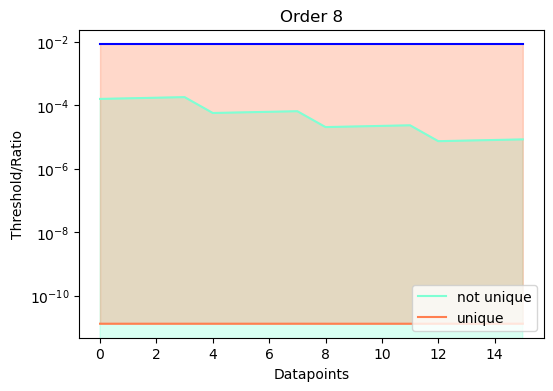

In [153]:
# Create subplots
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4))
n=len(svs.flatten())
ax.set_title(f"Order {fd_order}")
ax.plot( svs.flatten(),color='blue')
ax.fill_between(np.arange(n),lower_bounds.flatten(), 0,color='aquamarine', alpha=0.3)
ax.plot(lower_bounds.flatten(),label="not unique",color='aquamarine')
ax.set_ylabel('Threshold/Ratio')


ax.fill_between(np.arange(n),upper_bounds.flatten(), y2=max(svs.flatten()), color='coral', alpha=0.3)
ax.set_yscale('log')
ax.plot(upper_bounds.flatten(),label="unique", color='coral')

ax.set_xlabel('Datapoints')
ax.legend(loc=4)

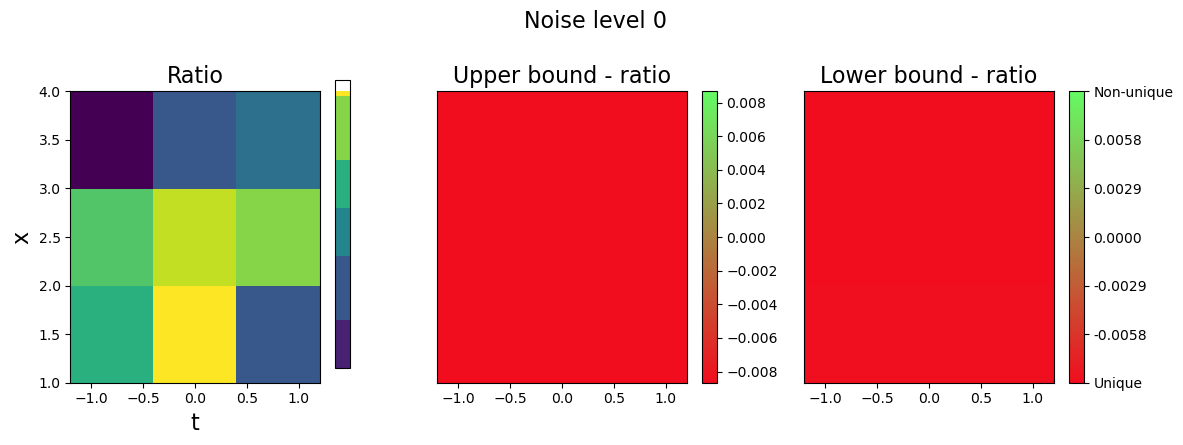

In [141]:
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
# Plot derivative results
subtitle_size=16
tickssize=16
order=fd_order
fig, axes = plt.subplots(1,3, figsize=(12,4))
plt.suptitle(f'Noise level 0', fontsize=subtitle_size,y=1.1)

#Plot the ratios
c = axes[0].pcolor(t_grid, x_grid, svs)
axes[0].set_title('Ratio', fontsize=tickssize)
axes[0].set_ylabel('x', fontsize=tickssize)
axes[0].set_xlabel('t', fontsize=tickssize)
fig.colorbar(c, ax=axes[0])

upper_minus_svs = upper_bounds - svs # <= 0 if unique >= 0 if non-unique
lower_minus_svs = lower_bounds - svs # <= 0 if unique >= 0 if non-unique
max_svs= np.max(np.abs(upper_minus_svs))
#Plot difference to upper bound
axes[1].set_title('Upper bound - ratio', fontsize=tickssize)
c=axes[1].pcolor(t_grid, x_grid, upper_minus_svs,cmap=cmap_red_green,vmin=-max_svs, vmax=max_svs)
axes[1].set_yticks([])
fig.colorbar(c, ax=axes[1])

#Plot difference to lower bound
max_svs= np.max(np.abs(lower_minus_svs))
axes[2].set_title('Lower bound - ratio', fontsize=tickssize)
c = axes[2].pcolor(t_grid, x_grid, lower_minus_svs, cmap=cmap_red_green, vmin=-max_svs, vmax=max_svs)
axes[2].set_yticks([])
cb = fig.colorbar(c, ax=axes[2])
ticks=np.linspace(-max_svs, max_svs,7) 
cb.set_ticks(ticks)
cb.set_ticklabels(['Unique', f'{ticks[1]:.4f}',f'{ticks[2]:.4f}',f'{ticks[3]:.4f}', f'{ticks[4]:.4f}', f'{ticks[5]:.4f}', 'Non-unique'])
plt.tight_layout()

### Test different noise levels on easy examples

In [127]:
def plot_results(upper_bounds, lower_bounds,svs,time_range,space_range,subtitle="",subtitle_size=16,tickssize=16):
    t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    #Plot the ratios
    c = axes[0].pcolor(t_grid, x_grid, svs)
    axes[0].set_title('Ratio', fontsize=tickssize)
    axes[0].set_ylabel('x', fontsize=tickssize)
    axes[0].set_xlabel('t', fontsize=tickssize)
    fig.colorbar(c, ax=axes[0])
    
    uupper_minus_svs = upper_bounds - svs # <= 0 if unique >= 0 if non-unique
    lower_minus_svs = lower_bounds - svs # <= 0 if unique >= 0 if non-unique
    max_svs= np.max(np.abs(upper_minus_svs))
    #Plot difference to upper bound
    plt.suptitle(subtitle, fontsize=subtitle_size,y=1.1)
    
    axes[1].set_title('Upper bound - ratio', fontsize=tickssize)
    c=axes[1].pcolor(t_grid, x_grid, upper_minus_svs,cmap=cmap_red_green,vmin=-max_svs, vmax=max_svs)
    axes[1].set_yticks
    fig.colorbar(c, ax=axes[1])
    
    #Plot difference to lower bound
    max_svs= np.max(np.abs(lower_minus_svs))
    axes[2].set_title('Lower bound - ratio', fontsize=tickssize)
    c = axes[2].pcolor(t_grid, x_grid, lower_minus_svs, cmap=cmap_red_green, vmin=-max_svs, vmax=max_svs)
    axes[2].set_yticks([])
    cb = fig.colorbar(c, ax=axes[2])
    ticks=np.linspace(-max_svs, max_svs,7) 
    cb.set_ticks(ticks)
    cb.set_ticklabels(['Unique', f'{ticks[1]:.4f}',f'{ticks[2]:.4f}',f'{ticks[3]:.4f}', f'{ticks[4]:.4f}', f'{ticks[5]:.4f}', 'Unique'])
    #plt.savefig(f"Images/JRC_{subtitle}")
    plt.tight_layout()


In [128]:
def get_results(space_range,time_range,u,fd_order,dt,dx,eps):
    
    ut_fd, utx_fd,ux_fd, uxx_fd= get_derivatives(u,dt,dx,fd_order)
    #For saving results
    svs = np.zeros([space_range, time_range])
    upper_bounds = np.zeros([space_range, time_range])
    lower_bounds = np.zeros([space_range, time_range])  
    
    for i in range(space_range):
        for j in range(time_range):
            x_i, t_j = i * 10 + 10, j * 10 + 10
            jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
            
            sv_fd = svd(jacobian_fd, compute_uv=False)
            sv_min =sv_fd[-1]
            sv_max =sv_fd[0]
    
            #Save the results 
            svs[i,j] = sv_min/sv_max
            C1=sv_max*1.5
            C=sv_max*0.5
            C2=max(1e-7,sv_min*0.5)

            upper_bound_jacobian = get_upper_bound_jacobian(eps,fd_order,infinity_norm(a**(fd_order+1)*u),
                                                infinity_norm(u),infinity_norm(u),infinity_norm(ut),dt,dx)
            
            lower_bound = lower_bound_nonsingular_matrix(C1,C2,upper_bound_jacobian)
            upper_bound = upper_bound_singular_matrix(C,upper_bound_jacobian)

            lower_bounds[i,j]=lower_bound
            upper_bounds[i,j]=upper_bound
    return svs, lower_bounds,upper_bounds

In [130]:
M=infinity_norm(u)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
noise_levels [0,1e-08,1e-05,1e-02]
orders=range(2,10,2)
unorm2=np.sqrt(np.mean(np.square(u)))

for noise_level in noise_levels:    
    
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    eps = infinity_norm(u-u_noise)
    
    print(f"Noise level {noise_level}")
    fd_orders=(2,8)
    svs, lower_bounds,upper_bounds = get_results(space_range,time_range,u_noise,fd_orders[0],dt,dx,eps)
    plot_results(upper_bounds, lower_bounds,svs,time_range,space_range,subtitle=f"Noise level {noise_level}, Order {fd_orders[0]}")
    print(svs)
    print(lower_bounds)
    print(upper_bound)
    #svs, lower_bounds,upper_bounds = get_results(space_range,time_range,u_noise,fd_orders[1],dt,dx,eps)
    #plot_results(upper_bounds, lower_bounds,svs,time_range,space_range,subtitle=f"Noise level {noise_level}, Order {fd_orders[1]}")

TypeError: list indices must be integers or slices, not tuple

## Try it on different examples

In [26]:
experiment_names= ['algebraic_nonunique_kdv','algebraic_nonunique_1','analytic_unique_1','analytic_unique_2','analytic_nonunique_1']

### Perform on one experiment

analytic_unique_2
(t + x)*asin(1/cosh(0.979663709993407*t))


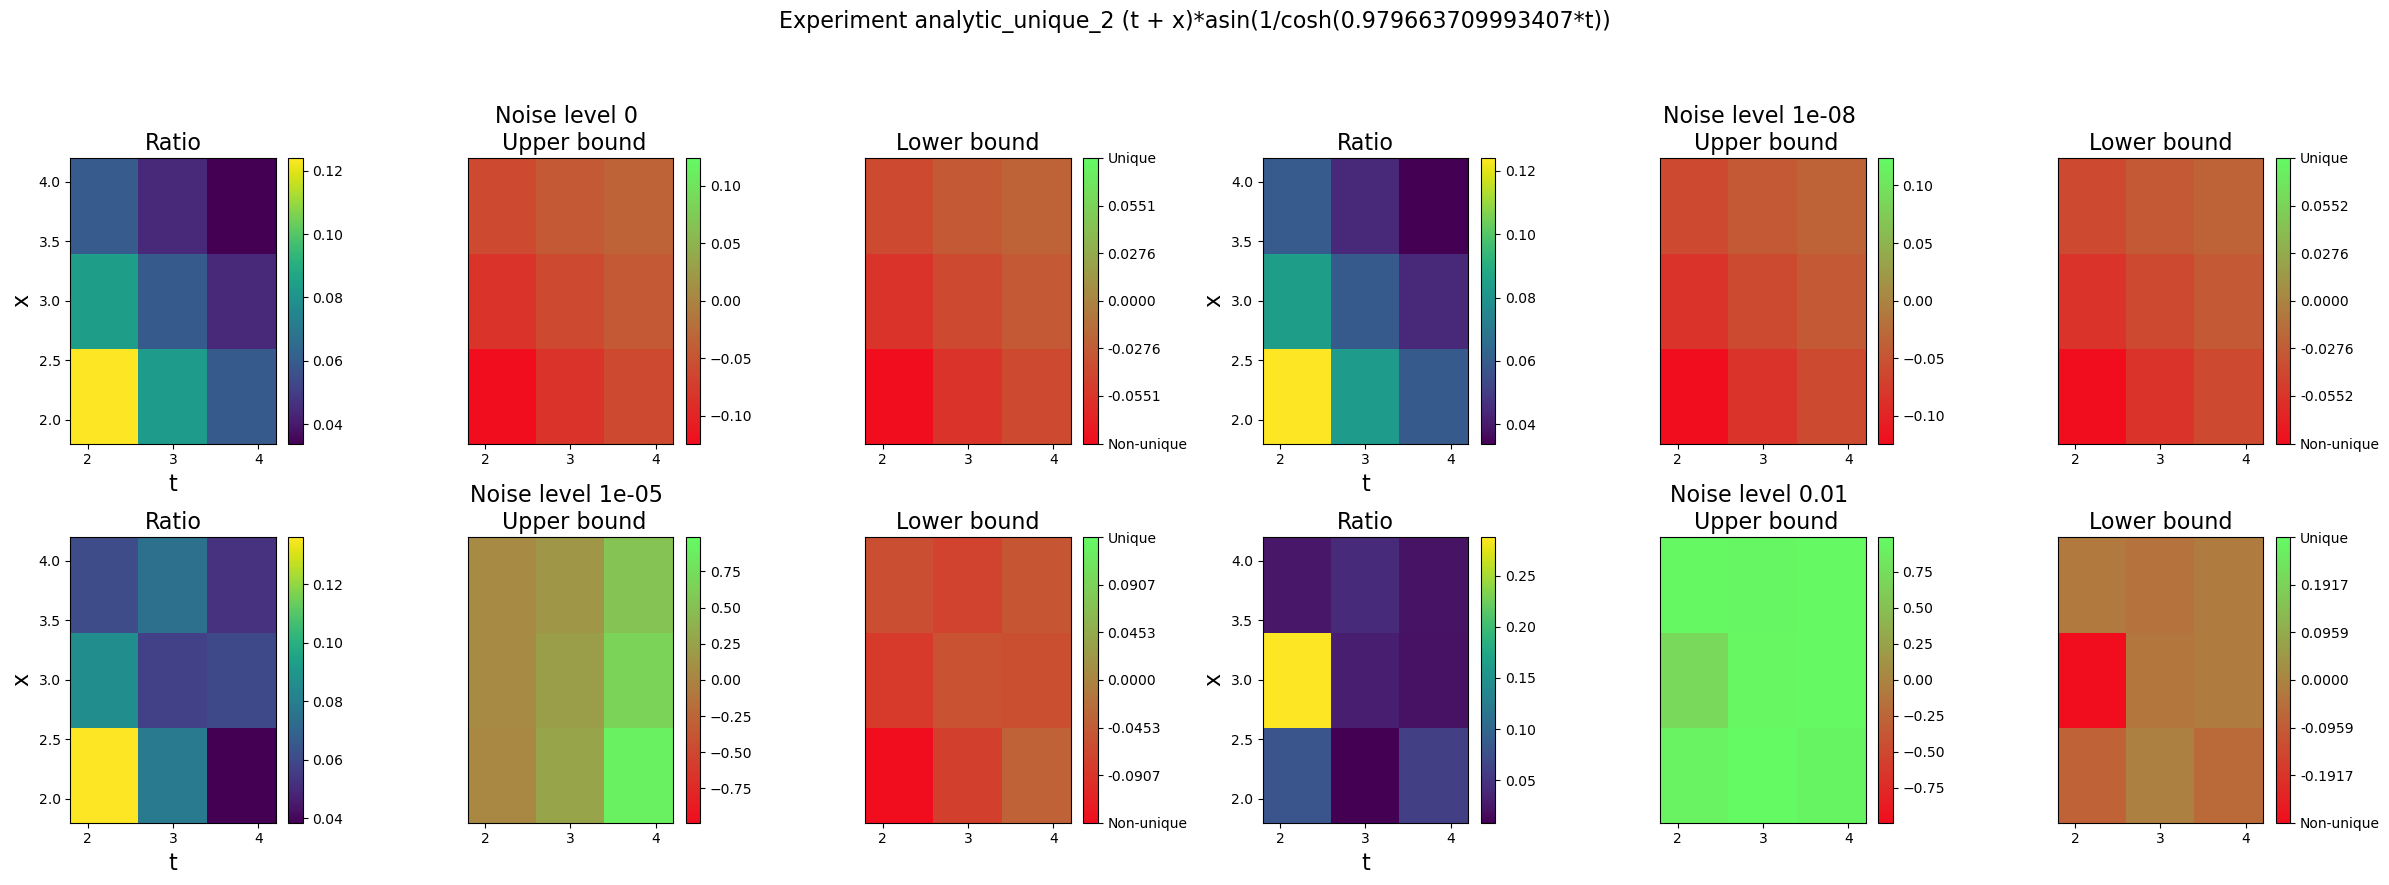

In [27]:
noise_levels = [0,1e-08,1e-05,0.01]
fd_orders=(2,8)
experiment_name = experiment_names[3]
#Get data
u,x,t,formula = experiment_data(n_samples=50,experiment_name=experiment_name)
dx=x[1]-x[0]
dt=t[1]-t[0]
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)
print(experiment_name)
print(formula)
subtitle=f"Experiment {experiment_name} {formula}"

t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
fig, axes = plt.subplots(2,6, figsize=(24,8))

for i,noise_level in enumerate(noise_levels):
    u_noise = add_noise(u,noise_level)
    eps = infinity_norm(u-u_noise)
    
    svs, lower_bounds,upper_bounds = get_results(space_range,time_range,u_noise,fd_order,dt,dx,eps)
 
    #Plot the ratios

    c = axes[i//2,i*3%6+0].pcolor(t_grid, x_grid, svs)
    axes[i//2,i*3%6+0].set_title('Ratio', fontsize=tickssize)
    axes[i//2,i*3%6+0].set_ylabel('x', fontsize=tickssize)
    axes[i//2,i*3%6+0].set_xlabel('t', fontsize=tickssize)
    fig.colorbar(c, ax=axes[i//2,i*3%6])
    
    upper_minus_svs = upper_bounds - svs
    lower_minus_svs = lower_bounds -svs
    max_svs= np.max(np.abs(upper_minus_svs))
    #Plot difference to upper bound
    plt.suptitle(subtitle, fontsize=subtitle_size,y=1.1)
 
    
    axes[i//2,i*3%6+1].set_title(f'Noise level {noise_level} \n Upper bound - ratio', fontsize=tickssize)
    c=axes[i//2,i*3%6+1].pcolor(t_grid, x_grid, upper_minus_svs,cmap=cmap_red_green,vmin=-max_svs, vmax=max_svs)
    axes[i//2,i*3%6+1].set_yticks([])
    fig.colorbar(c, ax=axes[i//2,i*3%6+1])
    
   
    #Plot difference to lower bound
    lower_minus_svs = lower_bounds -svs
    max_svs= np.max(np.abs(lower_minus_svs))
    axes[i//2,i*3%6+2].set_title('Lower bound - ratio', fontsize=tickssize)
    c = axes[i//2,i*3%6+2].pcolor(t_grid, x_grid, lower_minus_svs, cmap=cmap_red_green, vmin=-max_svs, vmax=max_svs)
    axes[i//2,i*3%6+2].set_yticks([])
    cb = fig.colorbar(c, ax=axes[i//2,i*3%6+2])
    ticks=np.linspace(-max_svs, max_svs,7) 
    cb.set_ticks(ticks)
    cb.set_ticklabels(['Non-unique', f'{ticks[1]:.4f}',f'{ticks[2]:.4f}',f'{ticks[3]:.4f}', f'{ticks[4]:.4f}', f'{ticks[5]:.4f}', 'Unique'])
    #plt.savefig(f"Images/JRC_{subtitle}")
    plt.tight_layout()


### Perform on all experiments

In [28]:
def perform_experiment(noise_levels,fd_order,experiment_name):
    
    #Get data,
    u,x,t,formula = experiment_data(n_samples=50,experiment_name=experiment_name)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    space_range = int(len(x)/10-1)
    time_range = int(len(x)/10-1)
    print(f"Performing experiment {experiment_name} {formula} with order {fd_order}")
    subtitle=f"Experiment {experiment_name} {formula}, Order {fd_order}"
    
    t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
    fig, axes = plt.subplots(2,6, figsize=(24,8))
    
    for i,noise_level in enumerate(noise_levels):
        u_noise = add_noise(u,noise_level)
        eps = infinity_norm(u-u_noise)
        
        svs, lower_bounds,upper_bounds = get_results(space_range,time_range,u_noise,fd_order,dt,dx,eps)
     
        #Plot the ratios
    
        c = axes[i//2,i*3%6+0].pcolor(t_grid, x_grid, svs)
        axes[i//2,i*3%6+0].set_title('Ratio', fontsize=tickssize)
        axes[i//2,i*3%6+0].set_ylabel('x', fontsize=tickssize)
        axes[i//2,i*3%6+0].set_xlabel('t', fontsize=tickssize)
        fig.colorbar(c, ax=axes[i//2,i*3%6])
        
        upper_minus_svs = upper_bounds - svs
        lower_minus_svs = lower_bounds -svs
        max_svs= np.max(np.abs(upper_minus_svs))
        #Plot difference to upper bound
        plt.suptitle(subtitle, fontsize=subtitle_size,y=1.1)
     
        
        axes[i//2,i*3%6+1].set_title(f'Noise level {noise_level} \n Upper bound - ratio', fontsize=tickssize)
        c=axes[i//2,i*3%6+1].pcolor(t_grid, x_grid, upper_minus_svs,cmap=cmap_red_green,vmin=-max_svs, vmax=max_svs)
        axes[i//2,i*3%6+1].set_yticks([])
        fig.colorbar(c, ax=axes[i//2,i*3%6+1])
        
       
        #Plot difference to lower bound
        lower_minus_svs = lower_bounds  -svs
        max_svs= np.max(np.abs(lower_minus_svs))
        axes[i//2,i*3%6+2].set_title('Lower bound - ratio', fontsize=tickssize)
        c = axes[i//2,i*3%6+2].pcolor(t_grid, x_grid, lower_minus_svs, cmap=cmap_red_green, vmin=-max_svs, vmax=max_svs)
        axes[i//2,i*3%6+2].set_yticks([])
        cb = fig.colorbar(c, ax=axes[i//2,i*3%6+2])
        ticks=np.linspace(-max_svs, max_svs,7) 
        cb.set_ticks(ticks)
        cb.set_ticklabels(['Non-unique', f'{ticks[1]:.4f}',f'{ticks[2]:.4f}',f'{ticks[3]:.4f}', f'{ticks[4]:.4f}', f'{ticks[5]:.4f}', 'Unique'])
        #plt.savefig(f"Images/JRC_{subtitle}")
        plt.tight_layout()


Performing experiment algebraic_nonunique_kdv 0.319226793342227/cosh(0.255072712719592*t - 0.399516453567451*x)**2 with order 2
Performing experiment algebraic_nonunique_kdv 0.319226793342227/cosh(0.255072712719592*t - 0.399516453567451*x)**2 with order 8
Performing experiment algebraic_nonunique_1 1/(t + x) with order 2
Performing experiment algebraic_nonunique_1 1/(t + x) with order 8
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.638453586684453*t)) with order 2
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.638453586684453*t)) with order 8
Performing experiment analytic_unique_2 (t + x)*asin(1/cosh(0.638453586684453*t)) with order 2
Performing experiment analytic_unique_2 (t + x)*asin(1/cosh(0.638453586684453*t)) with order 8
Performing experiment analytic_nonunique_1 sin(t + x) with order 2
Performing experiment analytic_nonunique_1 sin(t + x) with order 8


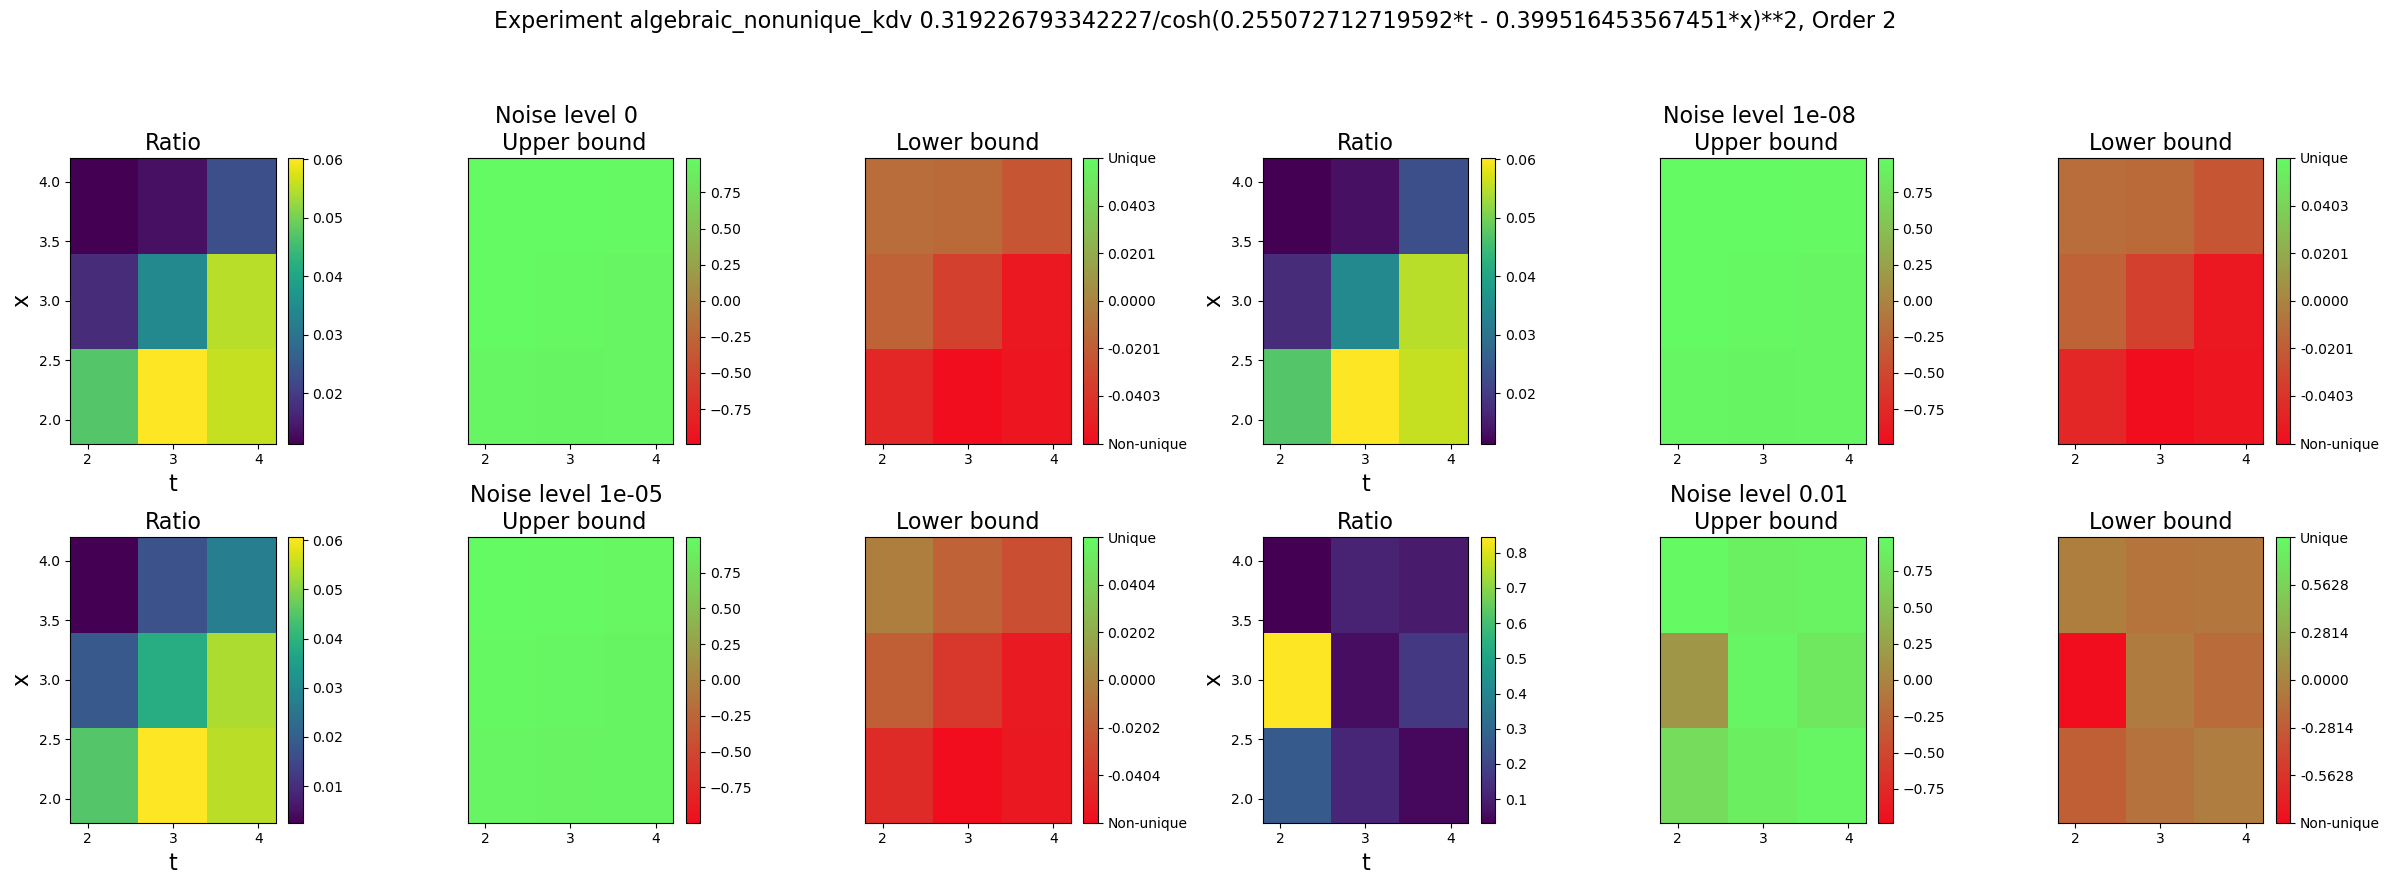

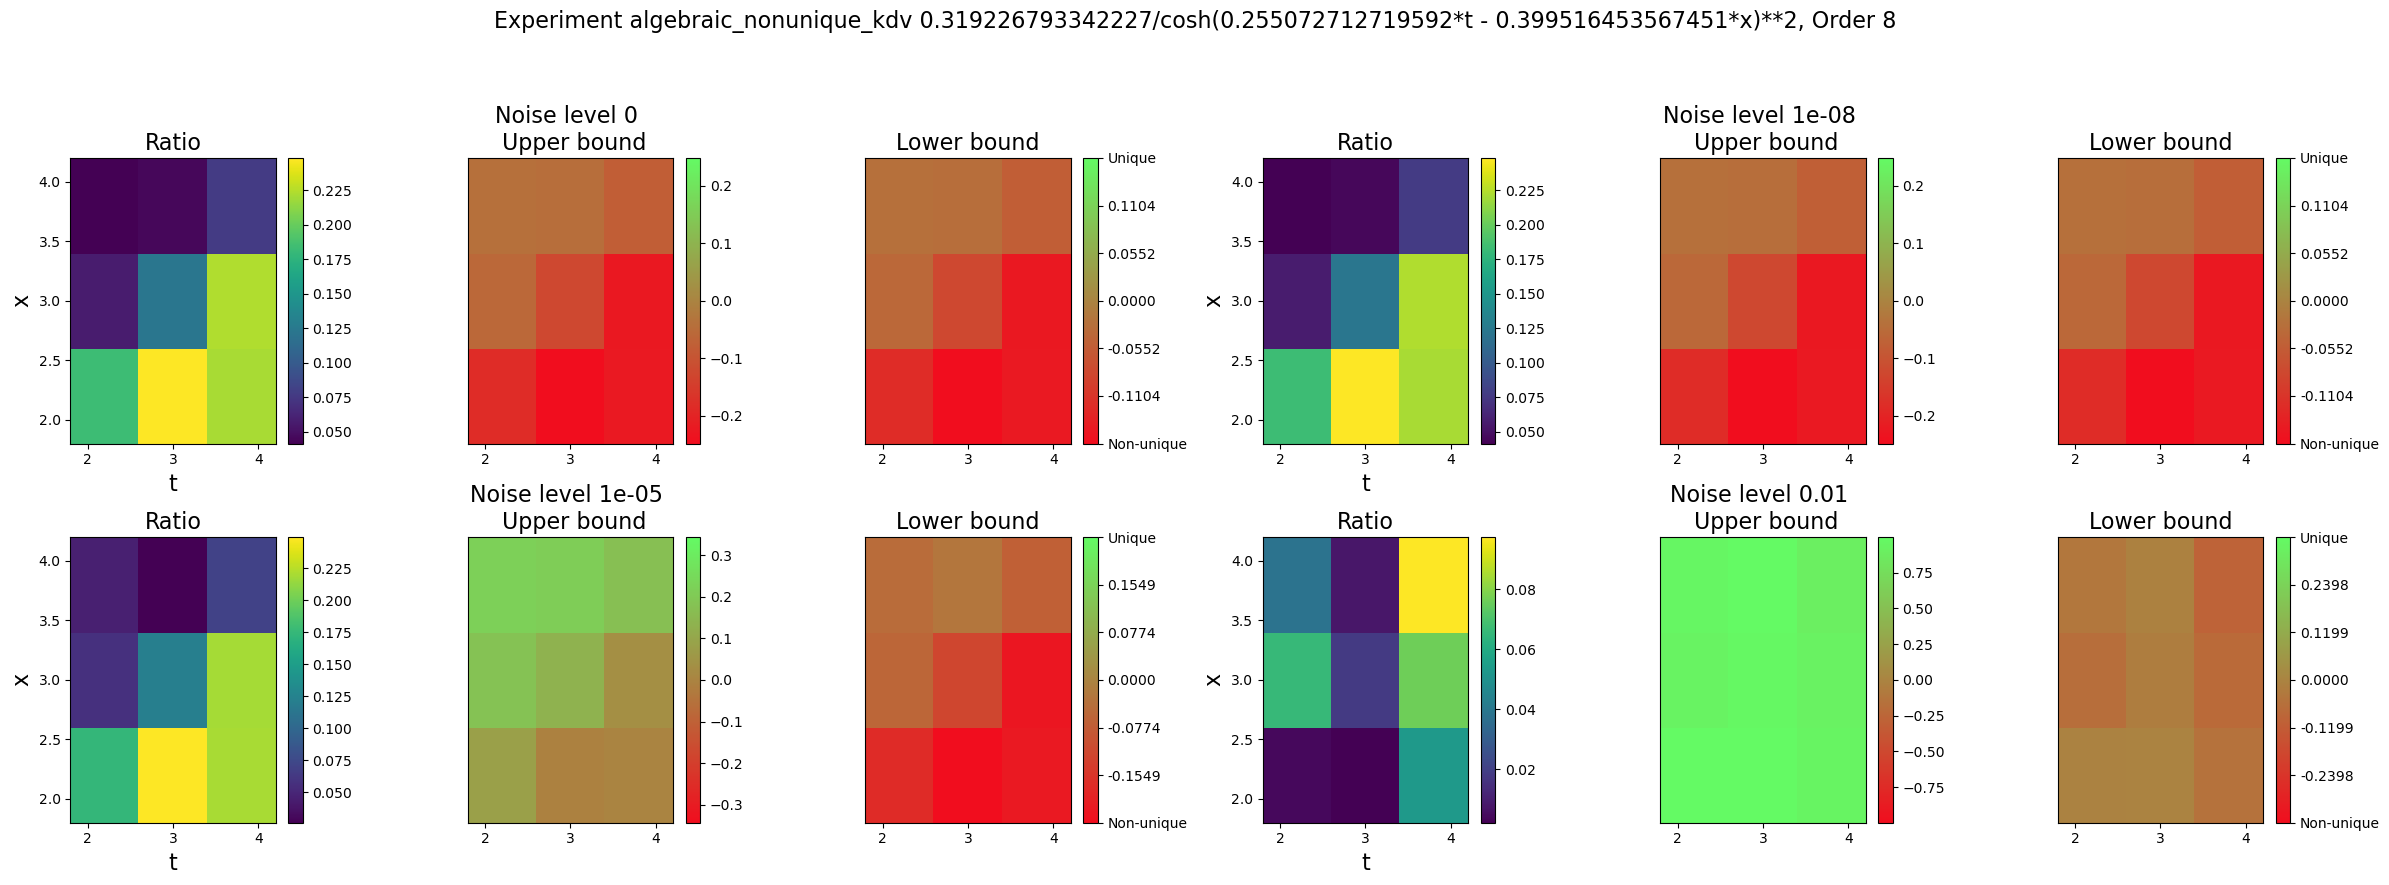

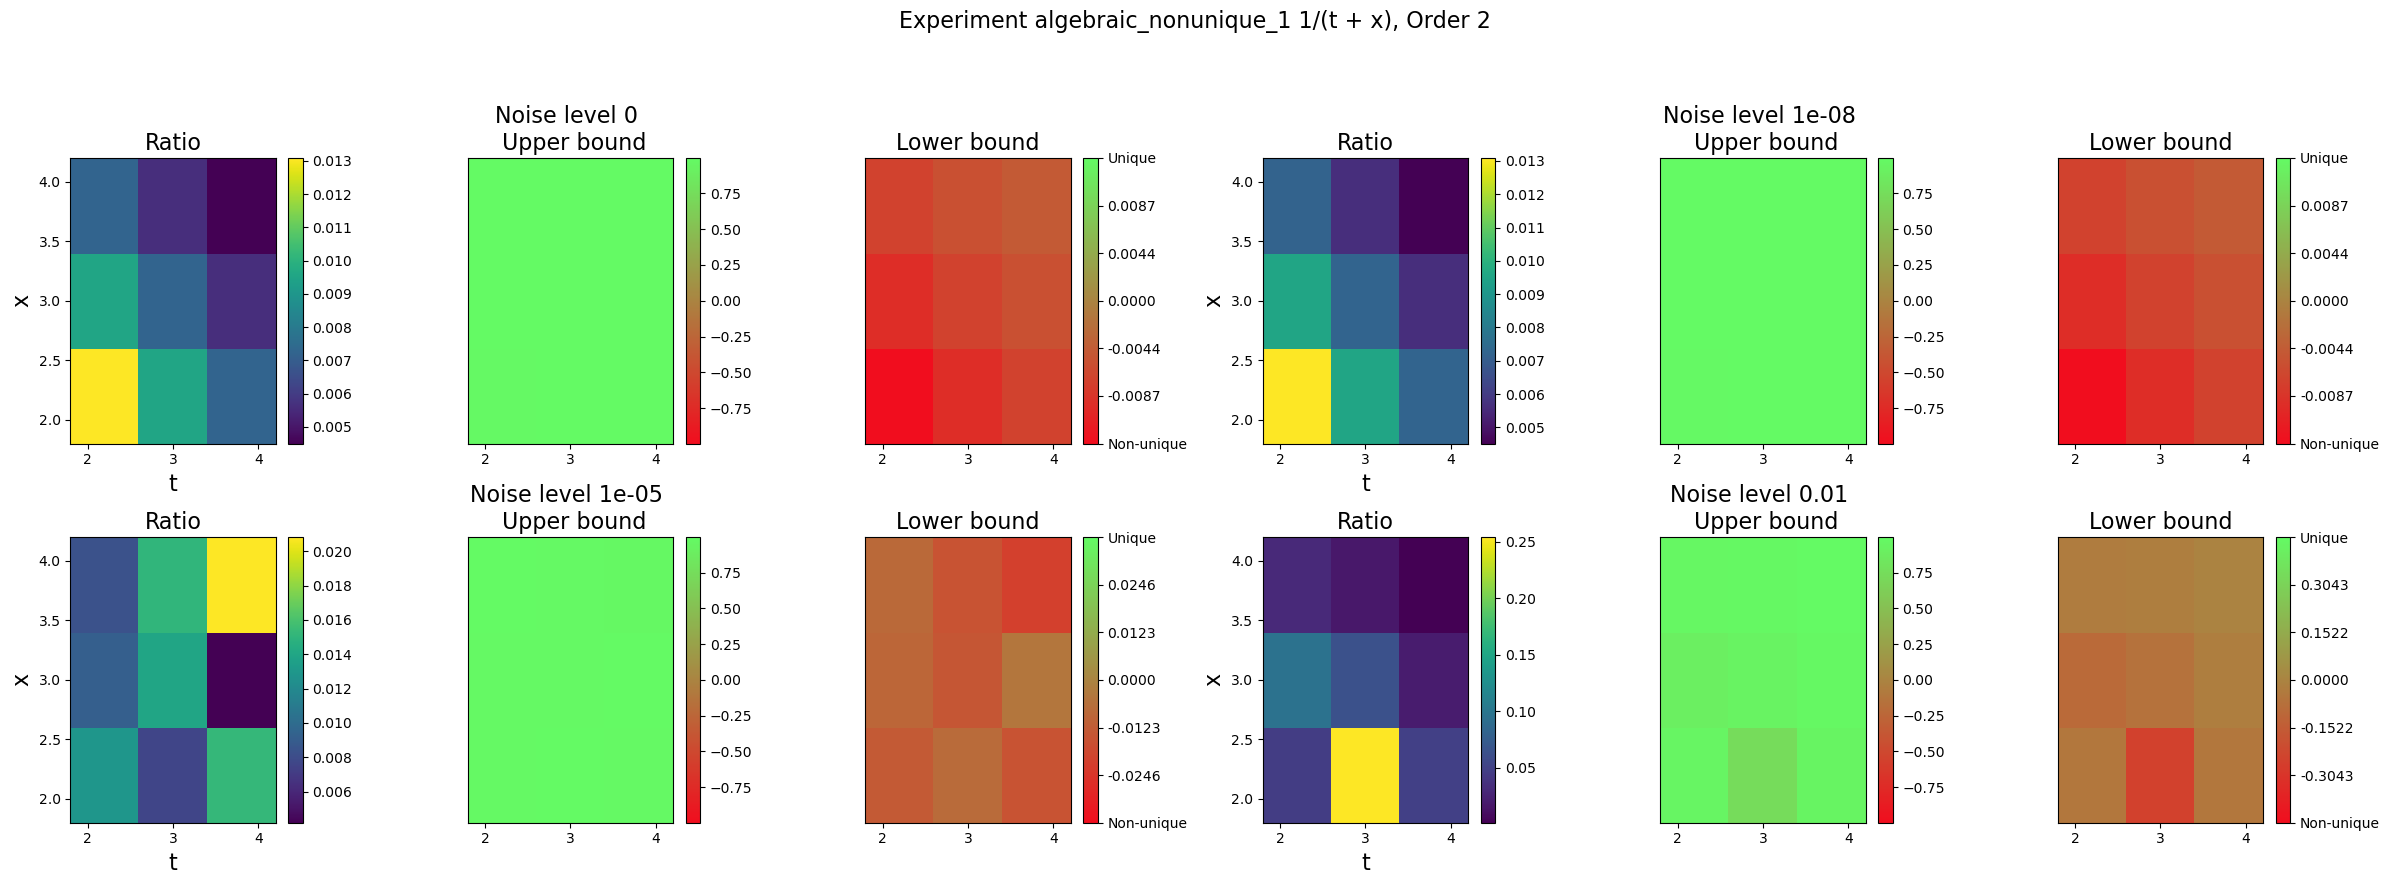

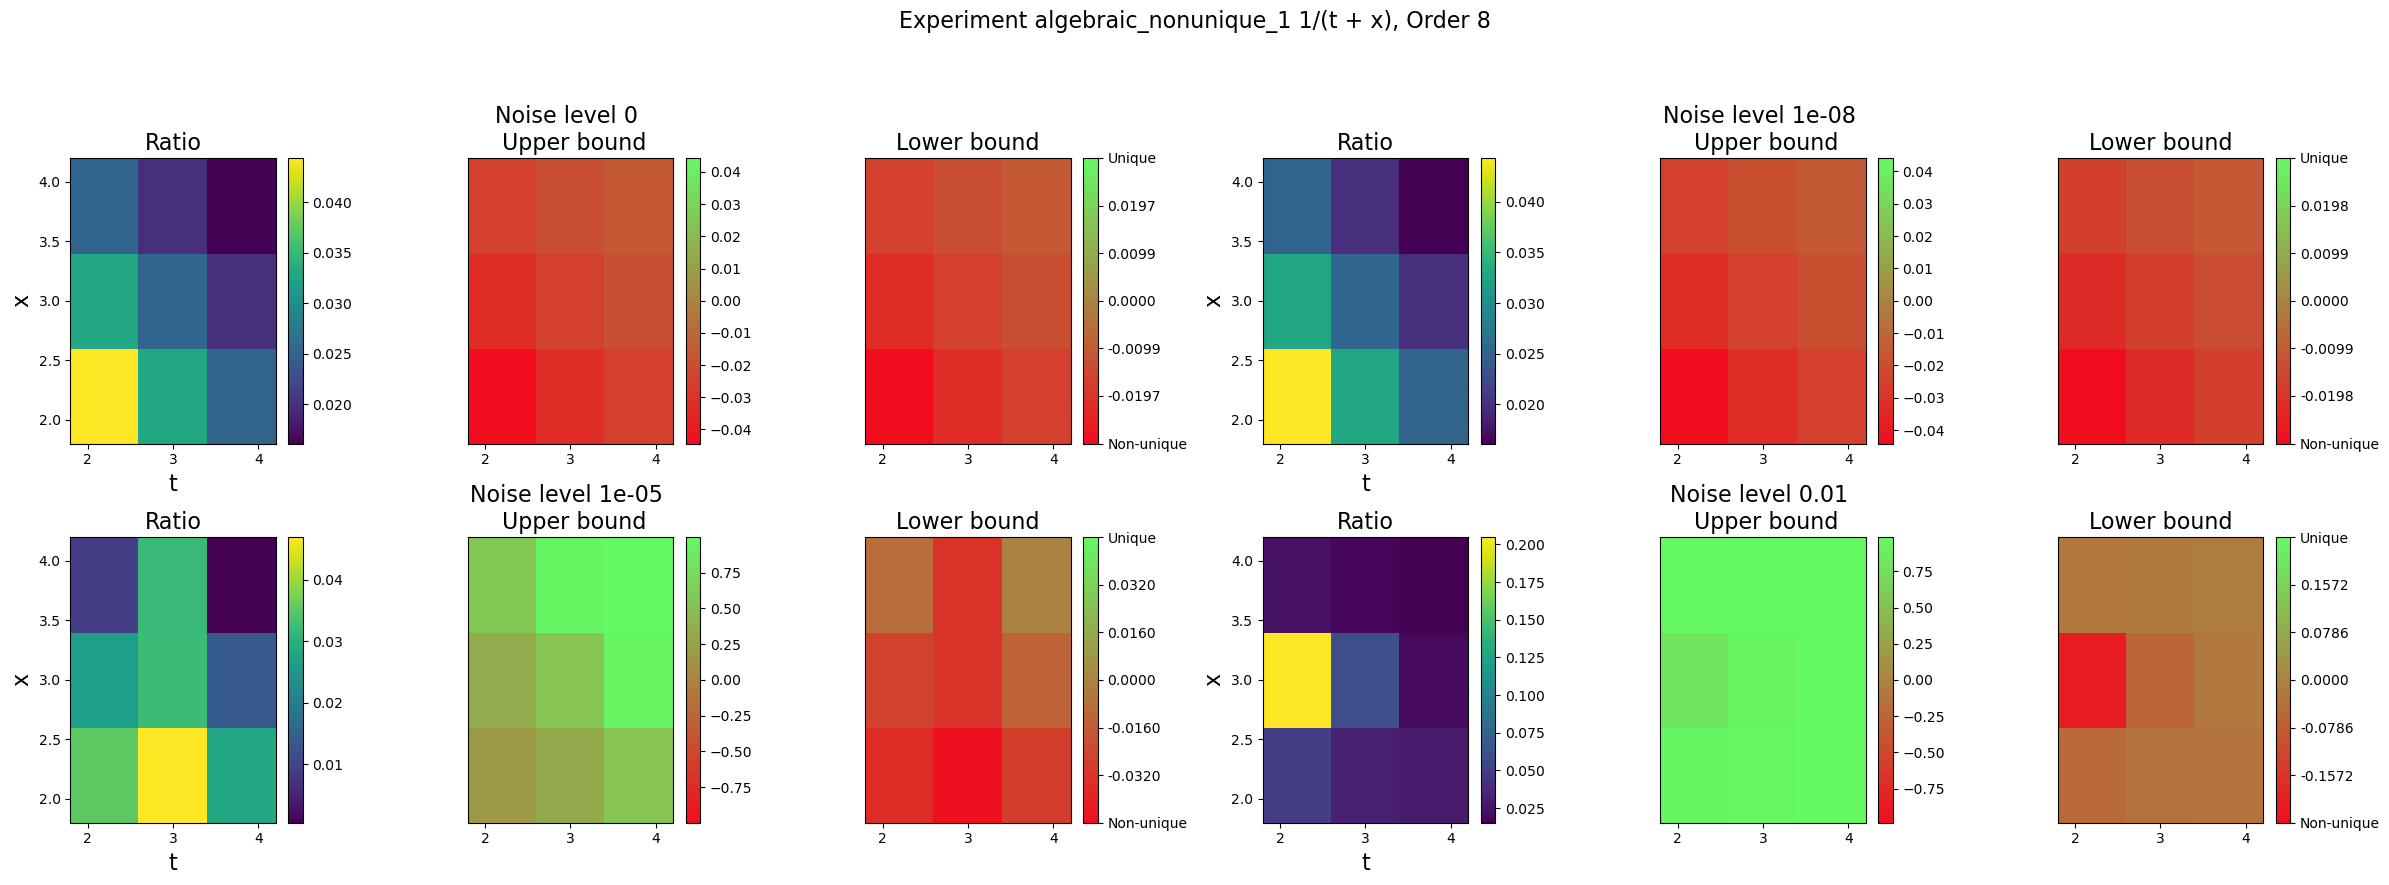

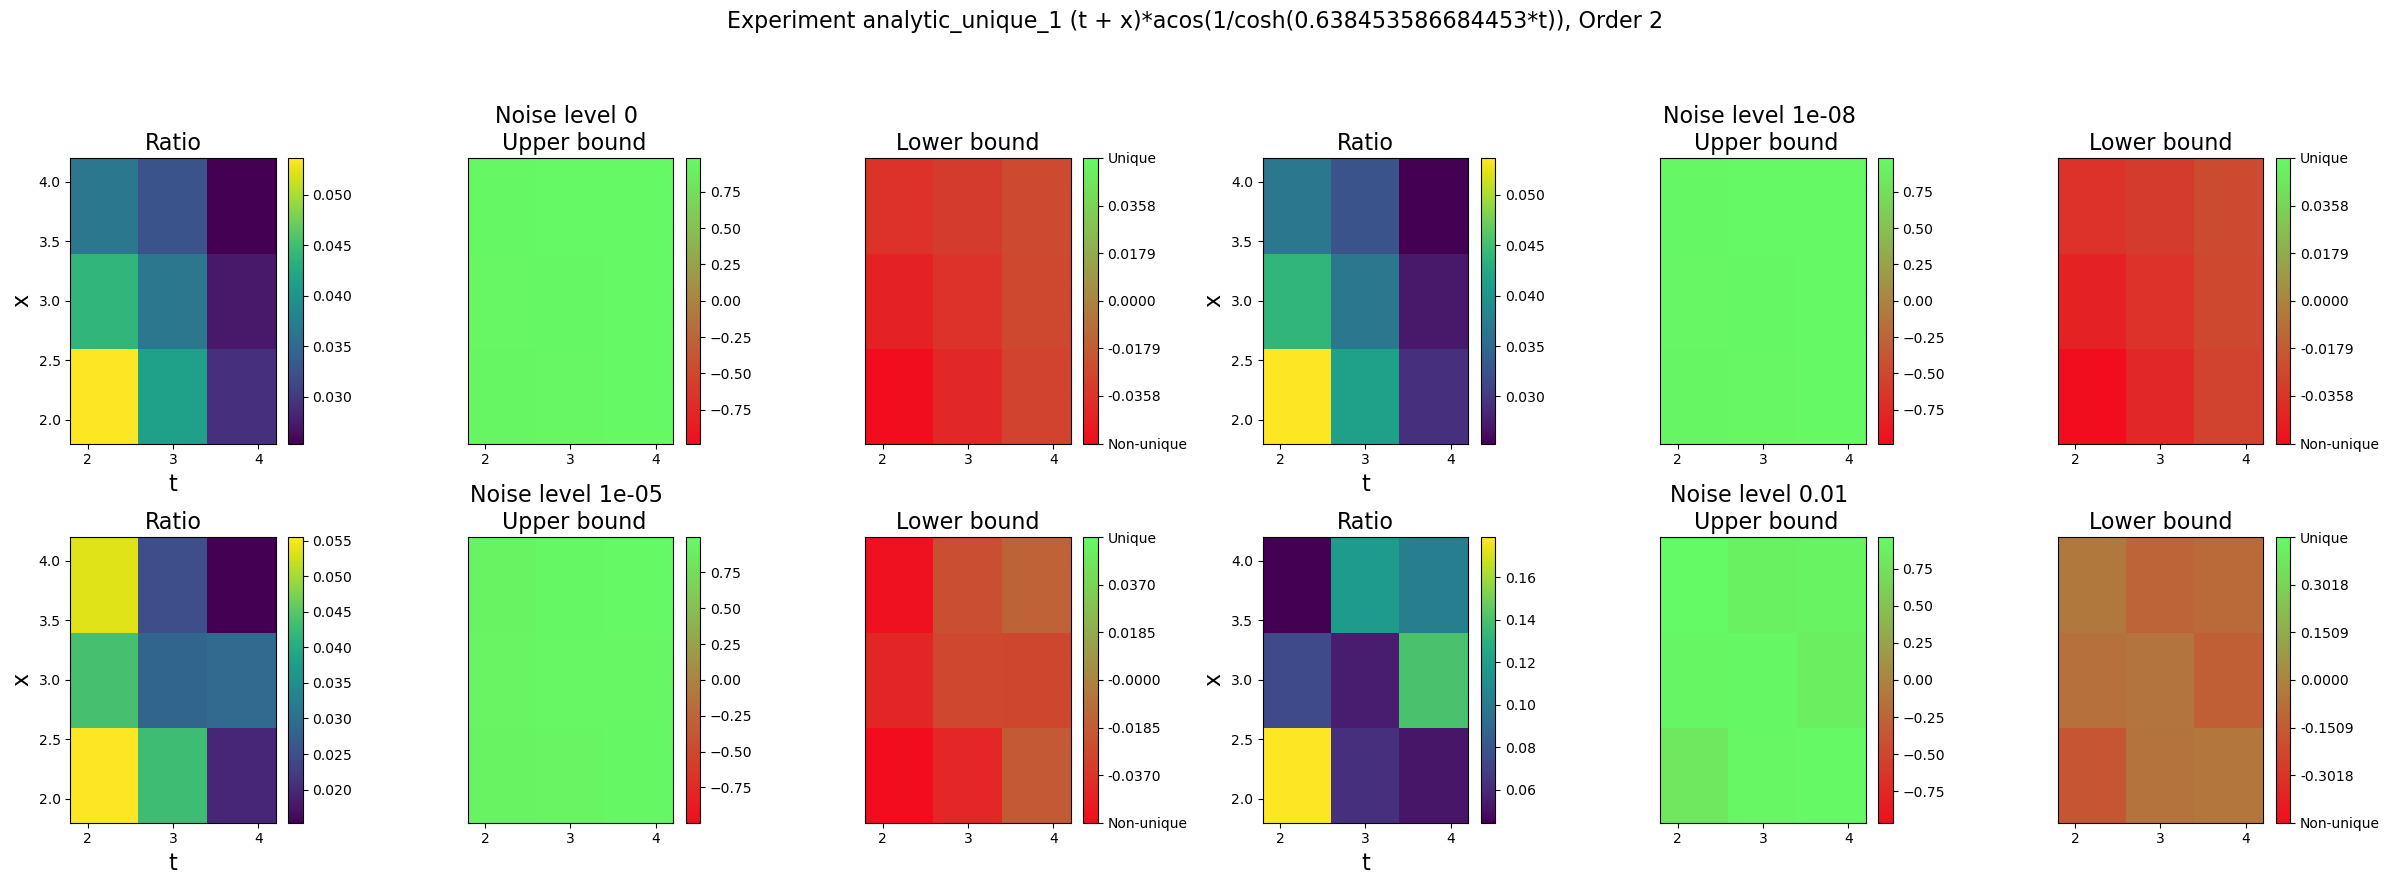

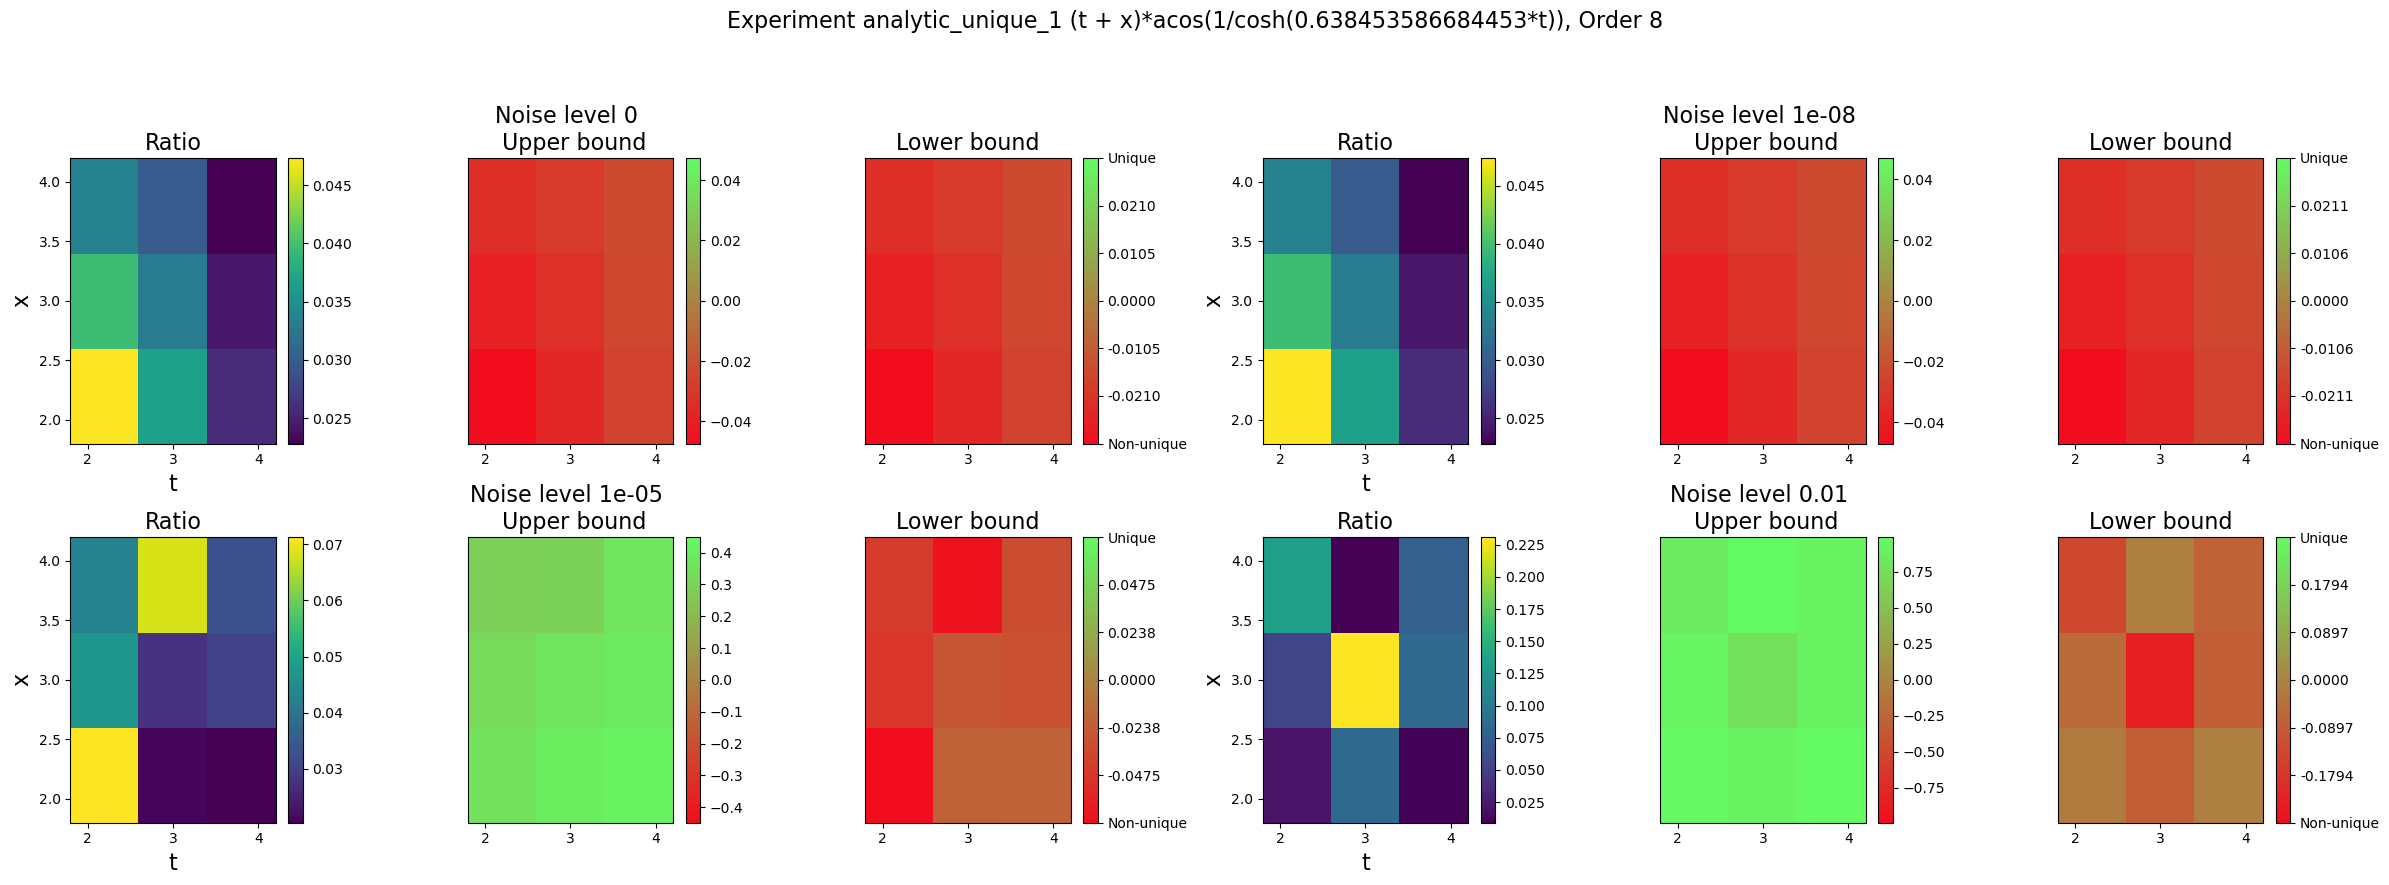

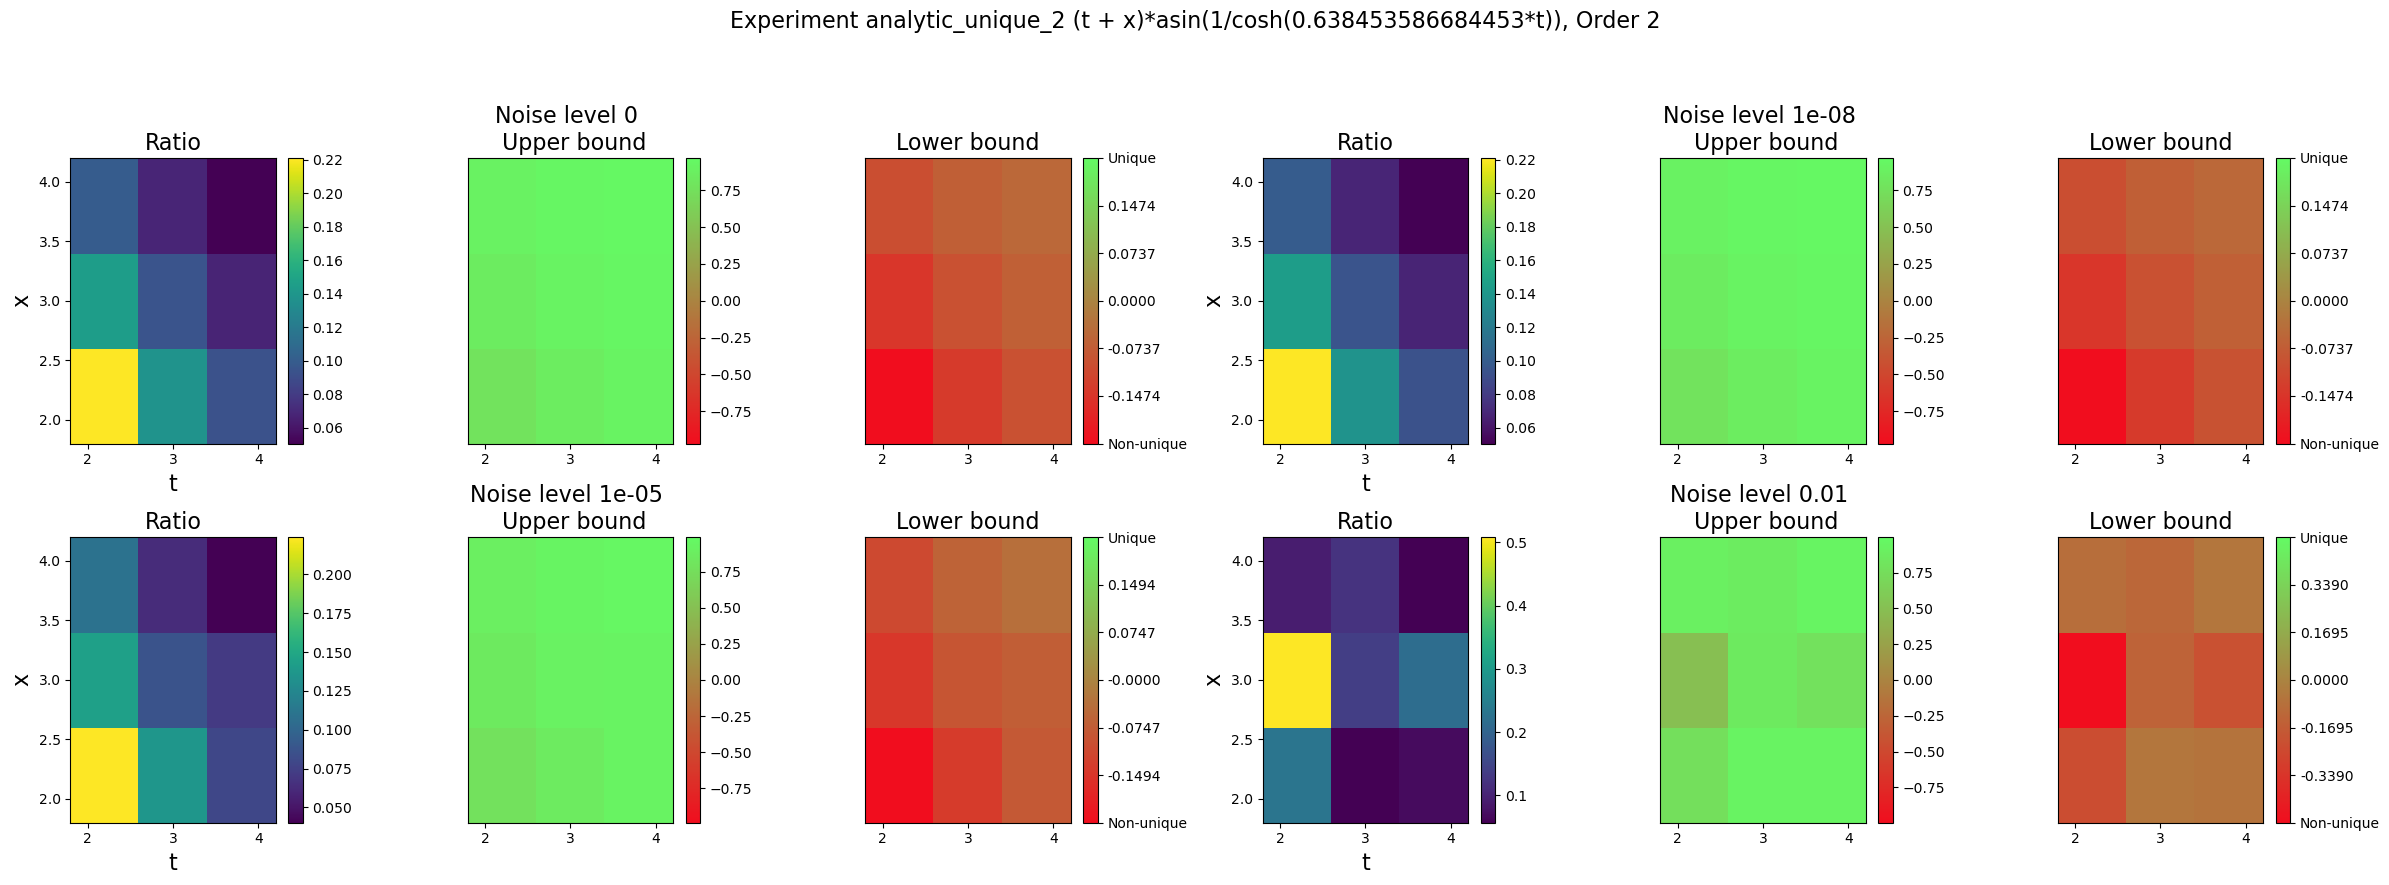

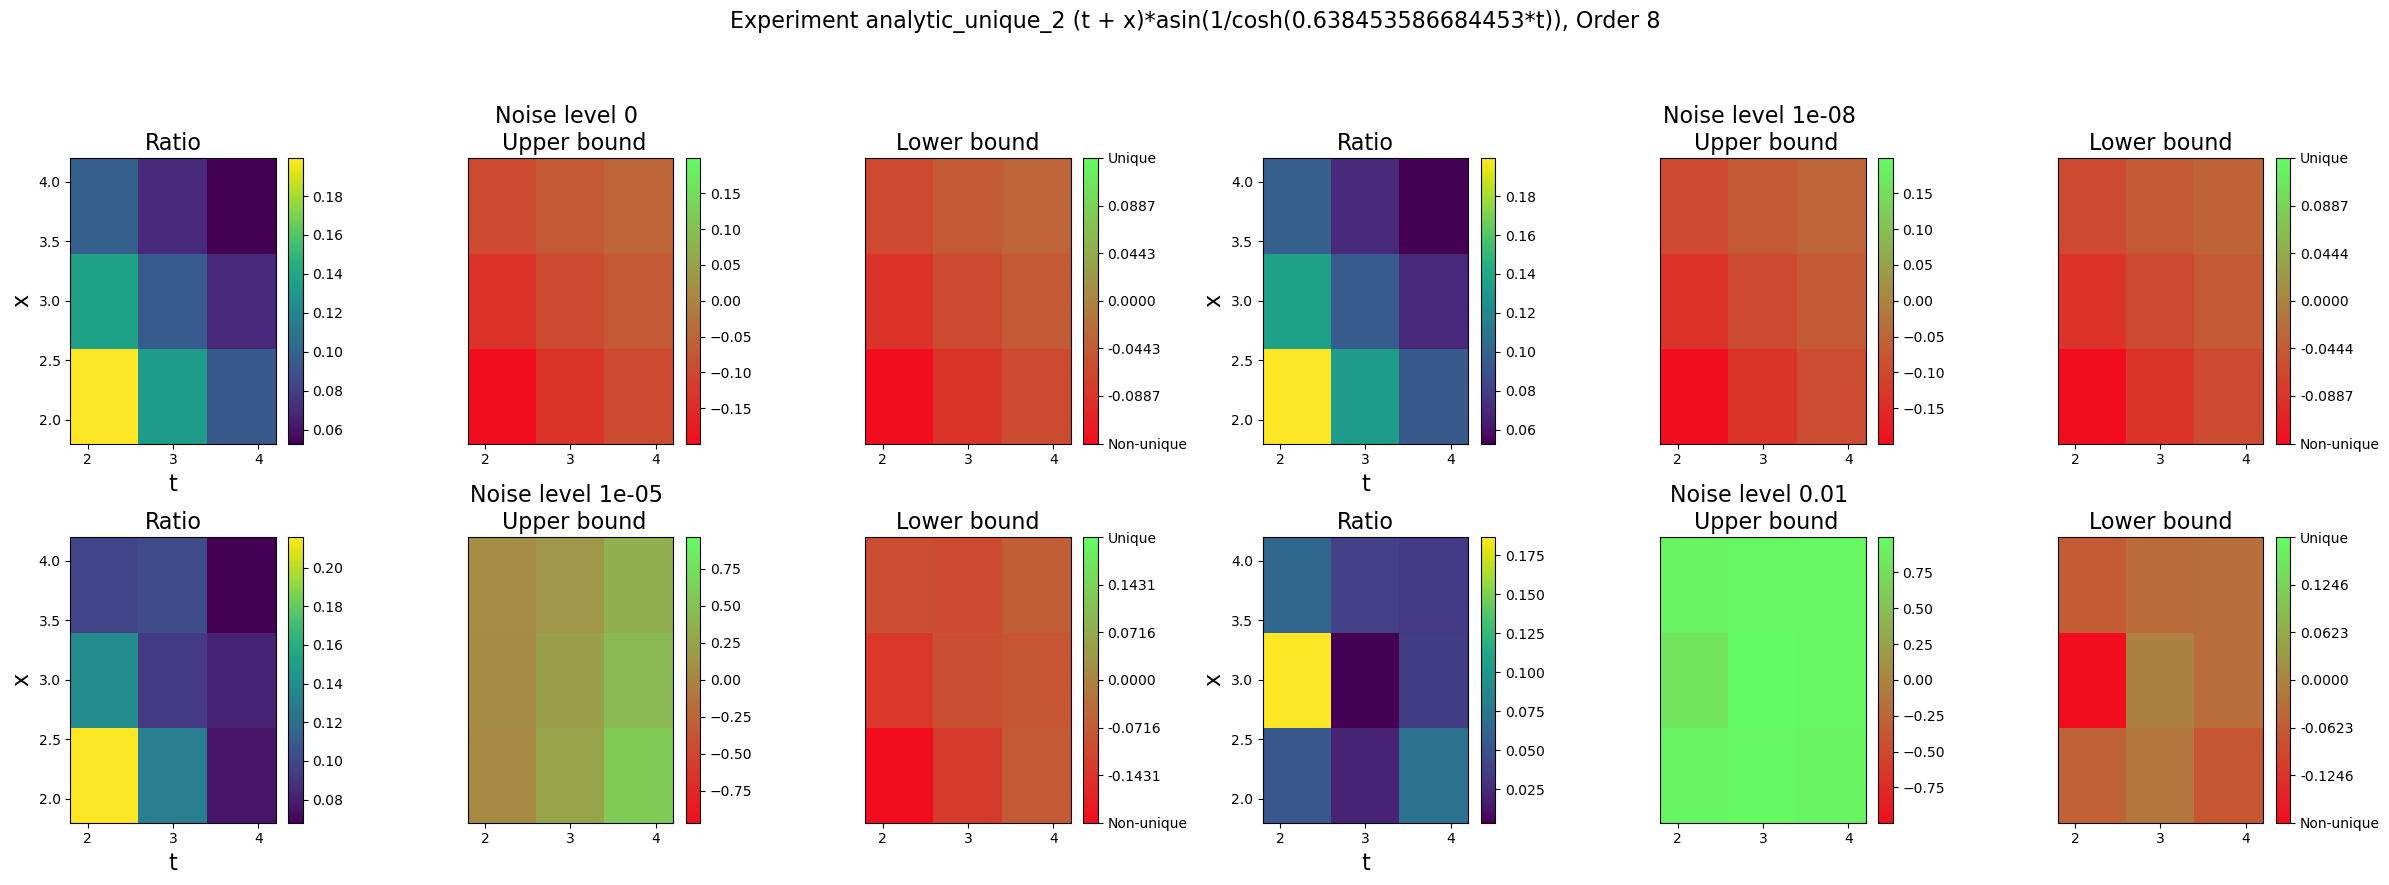

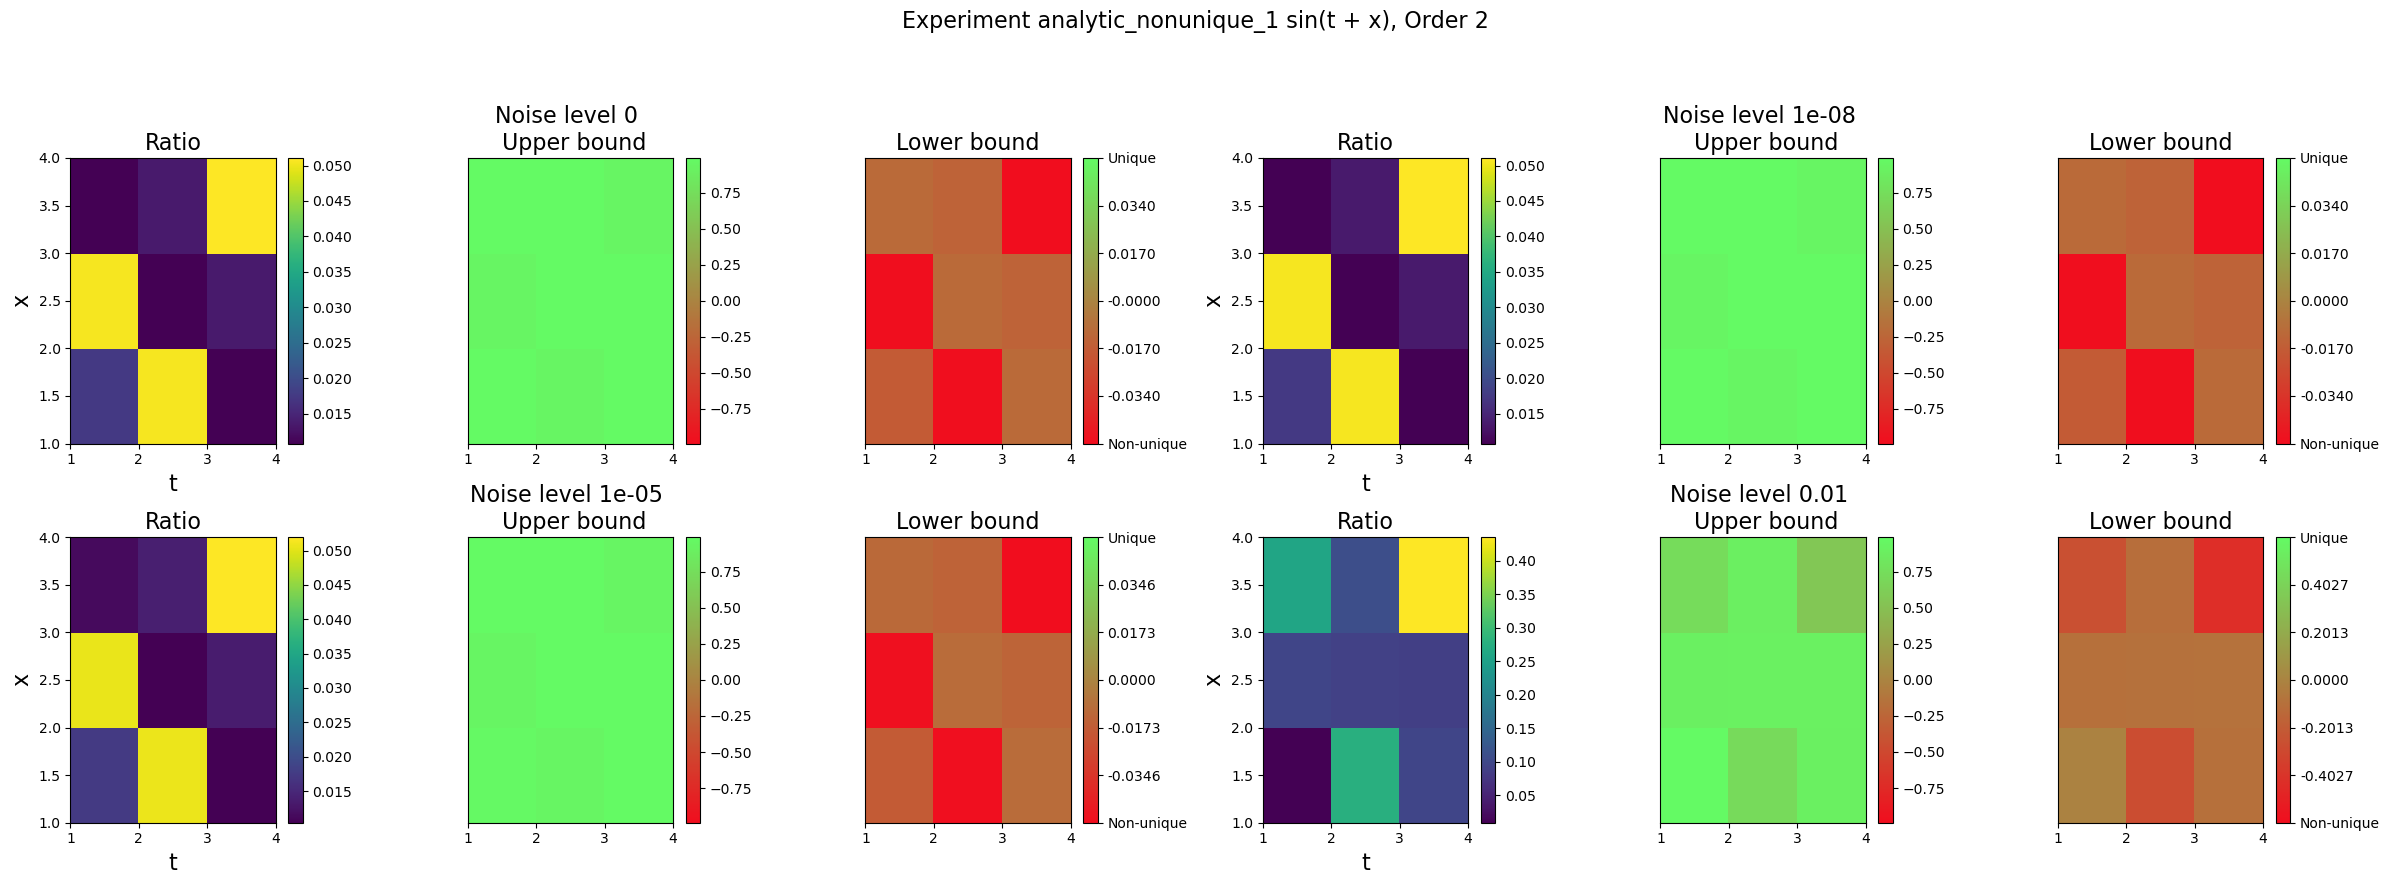

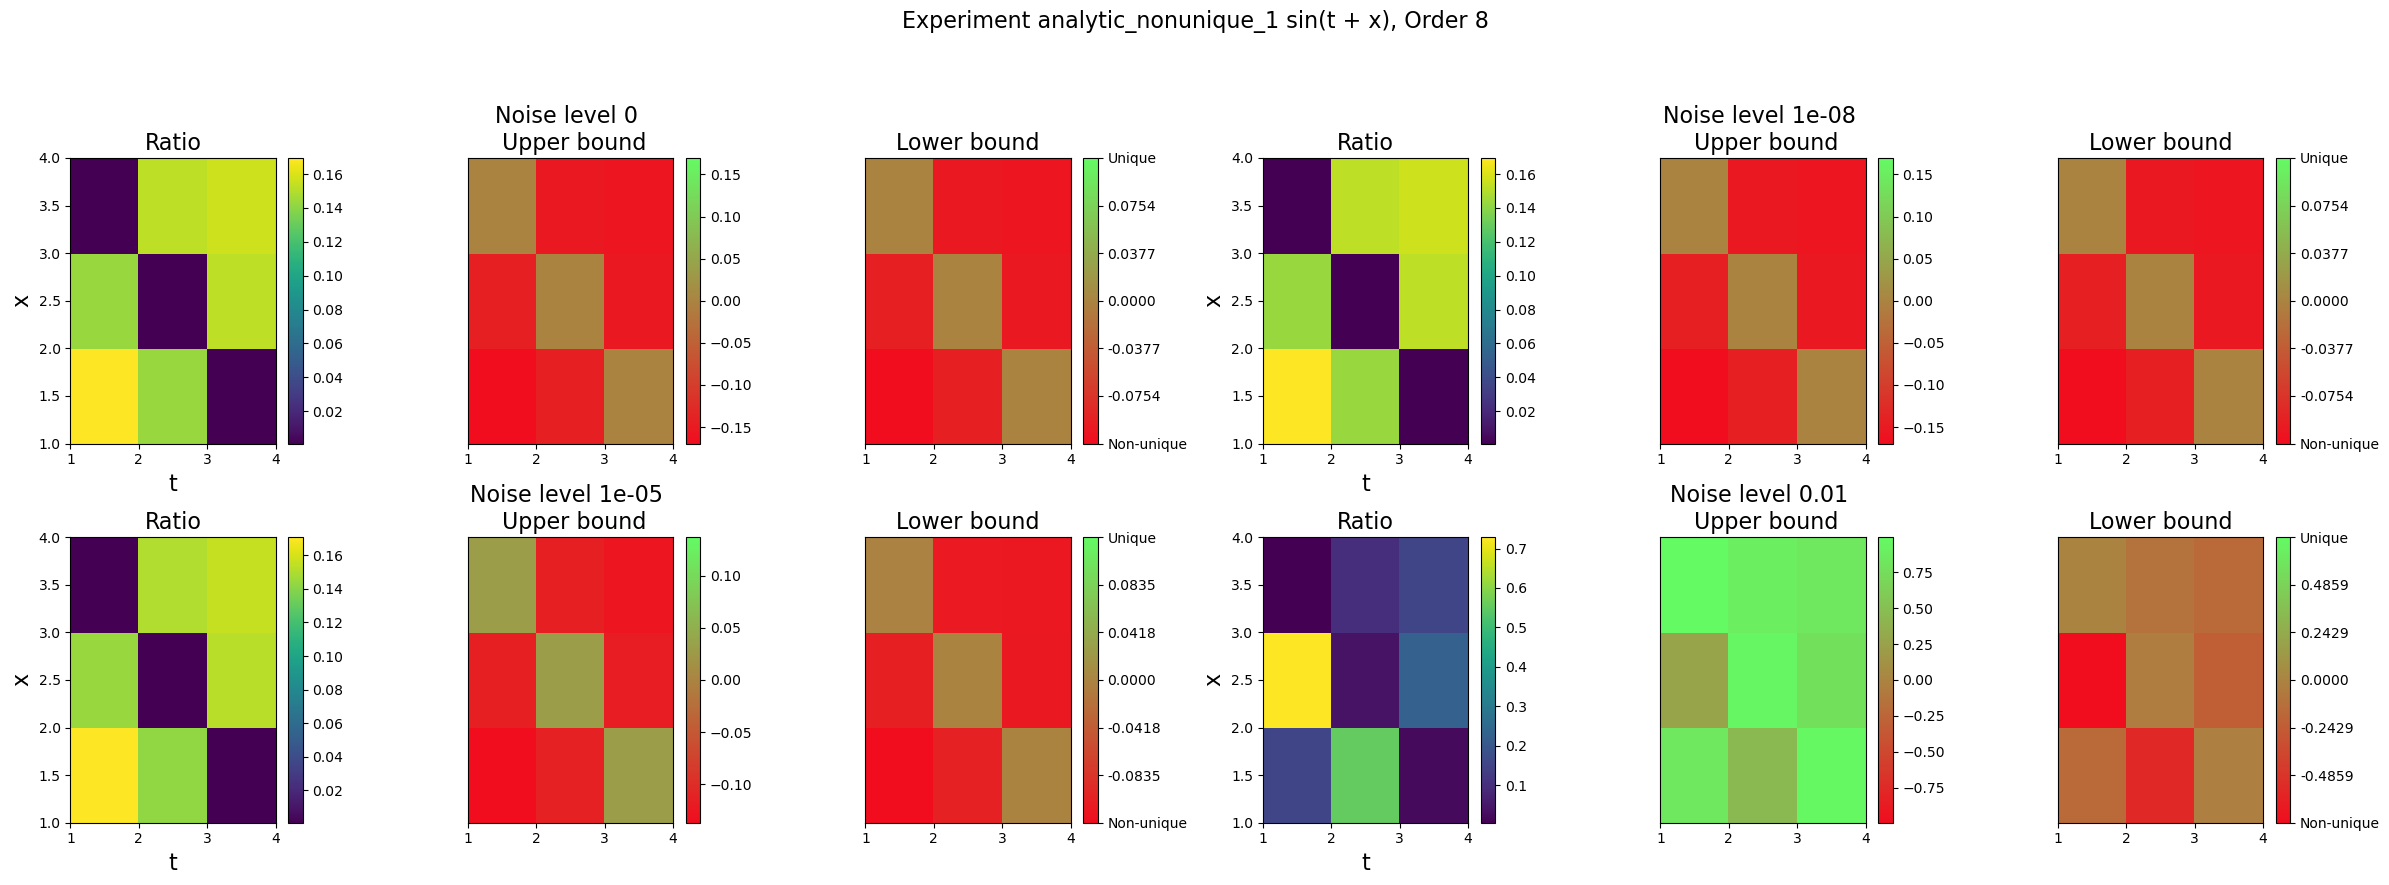

In [29]:
noise_levels = [0,1e-08,1e-05,0.01]
fd_orders=[2,8]
for experiment_name in experiment_names:
    for order in fd_orders:
        perform_experiment(noise_levels,order,experiment_name)